In [1]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot

# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for specific humidity
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for specific humidity
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for specific humidity
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    agg.columns = names

    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(84):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (specific_humidity) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(84):
        # transform into supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(21):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    # Transform each weather station as a separate "batch"
    for ws in range(21):
        # transform into supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 11:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 1
if n_seq > 46:
    n_lag = 179 - n_seq + 46
else:
    n_lag = 179
n_time_steps = 227
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([1, 2, 3, 5, 6, 7, 8, 9, 11, 13, 14, 15, 16, 17, 19, 20, 21, 22, 
                        23, 24, 25, 27, 28, 29, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 
                        43, 44, 46, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 
                        62, 63, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 81, 
                        82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 95, 97, 98, 100, 101, 102, 103])
test_array.append([0, 4, 10, 12, 18, 26, 30, 31, 33, 45, 47, 53, 64, 65, 77, 80, 89, 94, 96, 99, 104])
    
train_array.append([0, 1, 2, 3, 4, 6, 7, 8, 10, 12, 13, 14, 17, 18, 19, 20, 21, 23, 
                        24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 36, 37, 38, 41, 43, 45, 
                        46, 47, 48, 49, 50, 51, 52, 53, 54, 57, 58, 59, 60, 61, 63, 64, 
                        65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 77, 80, 81, 82, 83, 84, 
                        86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 104])
test_array.append([5, 9, 11, 15, 16, 22, 28, 35, 39, 40, 42, 44, 55, 56, 62, 72, 76, 78, 79, 85, 103])
    
train_array.append([0, 1, 2, 4, 5, 9, 10, 11, 12, 14, 15, 16, 18, 20, 21, 22, 23, 26, 
                    28, 29, 30, 31, 32, 33, 35, 36, 37, 39, 40, 41, 42, 44, 45, 46, 47, 
                    48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 
                    70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 82, 83, 85, 86, 87, 88, 89, 
                    90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104])
test_array.append([3, 6, 7, 8, 13, 17, 19, 24, 25, 27, 34, 38, 43, 49, 66, 67, 68, 69, 73, 81, 84])
    
train_array.append([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 
                        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 
                        35, 37, 38, 39, 40, 42, 43, 44, 45, 47, 49, 51, 52, 53, 55, 56, 
                        60, 62, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 76, 77, 78, 79, 
                        80, 81, 82, 84, 85, 86, 87, 88, 89, 92, 93, 94, 95, 96, 99, 102, 103, 104])
test_array.append([32, 36, 41, 46, 48, 50, 54, 57, 58, 59, 61, 63, 70, 75, 83, 90, 91, 97, 98, 100, 101])
    
train_array.append([0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 22,
                        24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 
                        42, 43, 44, 45, 46, 47, 48, 49, 50, 53, 54, 55, 56, 57, 58, 59, 
                        61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 75, 76, 77, 78, 
                        79, 80, 81, 83, 84, 85, 89, 90, 91, 94, 96, 97, 98, 99, 100, 101, 103, 104])
test_array.append([1, 2, 14, 20, 21, 23, 29, 37, 51, 52, 60, 71, 74, 82, 86, 87, 88, 92, 93, 95, 102])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Monthly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')

# Swap columns 'temperatures' and 'specific_humidity' directly
df['A'] = df['temperatures']
df['temperatures'] = df['specific_humidity']
df['specific_humidity'] = df['A']
df = df.drop(columns=['A'])
# Rename columns
df = df.rename(columns={'temperatures': 'specific_humidity', 'specific_humidity': 'temperatures'})

print(df)
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['Day', 'vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)

#Since the NaN values of GHI are gone which is used in data preparation, simulate these in solar activity instead
df['solar_activity'].loc[df['Year'] > 2020] = np.nan
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'Month', 'date', 'latitude', 'longitude', 'elevation'], axis=1)

#Test model and accuracy when solar activity is removed as a predictor
df_trimmed = df_trimmed.drop(['GHI'], axis=1)

n_vars = df_trimmed.shape[1]-1
    
X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    #new_df = new_df.iloc[:180, :]
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['specific_humidity'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['specific_humidity'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)
    
#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    for k in range(84):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df) 

    #print(len(dataset))
    #print(len(dataset[0]))
    #print(len(dataset_scaling))
    #print(len(dataset_scaling[:][0]))
    #print("Stop")
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(84):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['specific_humidity']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(21):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)     

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(21):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['specific_humidity']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(84):
        train2.append(train1[k][0])
        
    for k in range(11):
        test2.append(test1[k][0])

    for k in range(10):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + n_vars*n_lag
    train1 = np.array(train[i]).reshape(84, dim_size)
    test1 = np.array(test[i]).reshape(11, dim_size)
    validation1 = np.array(validation[i]).reshape(10, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
    #X_train = train1[:][:-n_seq]
    #y_train = train1[:][-n_seq:]
    #X_test = test1[:][:-n_seq]
    #y_test = test1[:][-n_seq:]

print("Finished")

Model Parameters:
n_lag (number of input time steps): 179
n_seq (number of output/future prediction time steps): 1
C:\Users\User
C:\Users\User\Modeling\
             date  file_id  specific_humidity          slp  vapor_pressure  \
0      2006-01-31     6501           5.386935  1018.534543        8.674922   
1      2006-02-28     6501           4.299929  1021.230347        6.942276   
2      2006-03-31     6501           6.505135  1018.968548       10.468176   
3      2006-04-30     6501          10.211263  1014.686944       16.358802   
4      2006-05-31     6501          11.737971  1014.236828       18.798749   
...           ...      ...                ...          ...             ...   
24057  2024-07-31     9858          15.211417  1013.969355       23.769169   
24058  2024-08-31     9858          15.149811  1015.112097       23.699154   
24059  2024-09-30     9858          10.720199  1014.393750       16.790240   
24060  2024-10-31     9858           6.989922  1018.230376       10

C:\Users\User\AppData\Local\Temp\ipykernel_47276\1851049394.py:383: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['solar_activity'].loc[df['Year'] > 2020] = np.nan


Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 1:
(84, 1, 1, 1970)
(11, 1, 1, 1970)
(10, 1, 1, 1970)
(84, 1, 1970)
(11, 1, 1970)
(10, 1, 1970)
(84, 1970)
(11, 1970)
(10, 1970)
[[0.42725031 0.69695044 0.32924264 ... 0.33095551 0.77165354 0.50924784]
 [0.45745993 0.51683609 0.42215989 ... 0.33095551 0.77165354 0.52342787]
 [0.43218249 0.62674714 0.3411641  ... 0.33095551 0.77165354 0.48766954]
 ...
 [0.47102343 0.46473952 0.46949509 ... 0.33095551 0.77165354 0.55487053]
 [0.43464858 0.51620076 0.3997195  ... 0.33095551 0.77165354 0.52959309]
 [0.44389642 0.52414231 0.42356241 ... 0.33095551 0.77165354 0.47040691]]
Fold 2:
(84, 1, 1, 1970)
(11, 1, 1, 1970)
(10, 1, 1, 1970)
(84, 1, 1970)
(11, 1, 1970)
(10, 1, 1970)
(84, 1970)
(11, 1970)
(10, 1970)
[[0.43464858 0.62313675 0.34639831 ... 0.33095551 0.77165354 0.48705302]
 [0.42725031 0.71548931 0.32450565 ... 0.33095551 0.77165354 0.50924784]
 [0.45745993 0.53175632 0.4180791  ... 0.33095551 0.77165354 0.52342787]
 ...
 [0.47102343 0.47861309 0.465

In [2]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

1
179
(84, 1970)
(11, 1970)


In [ ]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit an LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):

    cv_accuracies = []
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model

# make forecast with the CNN-LSTM best model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_lstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_lstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    rmse_list = []
    mae_list = []
    mape_list = []
    r2_list = []
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        mape = mean_absolute_percentage_error(actual, predicted)
        r2 = r2_score(actual, predicted) 
        rmse_list.append(rmse)
        mae_list.append(mae)
        mape_list.append(mape)
        r2_list.append(r2)
        print("Month at t+"+str(i+1)+":")
        print('t+%d RMSE: %f' % ((i+1), rmse))
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d MAPE: %f' % ((i+1), mape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))

    return rmse_list, mae_list, mape_list, r2_list
     
# plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, n_test):
    # plot the entire dataset in blue
    plt.plot(series.values)
    # plot the forecasts in red
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + forecasts[i]
        plt.plot(xaxis, yaxis, color='red')
    # show the plot
    plt.show()
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq]

    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:10, :]
    dataset = dataset_df.values

    series = pd.Series(dataset[:, 0]) # Using first column (specific_humidity)
    
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history=best_model.fit(X, y, epochs=nb_epoch, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test+2, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test+2, n_seq)

    rmse_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores root mean squared errors for each future time prediction
    mape_list = [] # list stores root mean squared errors for each future time prediction
    r2_list = [] # list stores root mean squared errors for each future time prediction
    
    # evaluate forecasts
    rmse_list, mae_list, mape_list, r2_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    for j in range(len(X_test)):
        print("Weather Station "+str(j+1)+":")
        dataset_df = pd.DataFrame(y_test[j].flatten())
        dataset = dataset_df.values
        dataset = dataset[:, 0]
        dataset = np.array(dataset).reshape(-1, 1)
        dataset = dataset.flatten()
        dataset = pd.DataFrame(dataset)
        series = scaler[i].inverse_transform(dataset)
        series = pd.Series(series.flatten())

    # plot forecasts
    plot_forecasts(series, forecasts, 1)
    
    best_model.summary()

    # Print out table of actual and predicted values for each weather station
    for j in range(11):
        print("Weather Station "+str(j+1)+":")
        print("Actual S.H.\tPredicted S.H.\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

[I 2025-05-15 20:33:39,796] A new study created in memory with name: no-name-67b49f19-5723-430d-a3af-97241d4b8323
[I 2025-05-15 20:38:08,032] Trial 0 finished with value: 0.039150845259428024 and parameters: {'lr': 0.039657951741131514, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.30497561549518726}. Best is trial 0 with value: 0.039150845259428024.


Cross Validation Accuracies:
[0.029306918382644653, 0.02531399205327034, 0.029033511877059937, 0.0792984664440155, 0.03280133754014969]
Mean Cross Validation Accuracy:
0.039150845259428024
Standard Deviation of Cross Validation Accuracy:
0.020213211386776255


[I 2025-05-15 20:46:26,882] Trial 1 finished with value: 0.057802758365869525 and parameters: {'lr': 0.006716631466366422, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.20329790155109895}. Best is trial 0 with value: 0.039150845259428024.


Cross Validation Accuracies:
[0.06010708585381508, 0.0255257710814476, 0.09942932426929474, 0.06300239264965057, 0.04094921797513962]
Mean Cross Validation Accuracy:
0.057802758365869525
Standard Deviation of Cross Validation Accuracy:
0.02486347860871312


[I 2025-05-15 20:54:25,853] Trial 2 finished with value: 0.06248687729239464 and parameters: {'lr': 0.1189015147338562, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.41719136438033433}. Best is trial 0 with value: 0.039150845259428024.


Cross Validation Accuracies:
[0.06443046033382416, 0.0600542277097702, 0.06782188266515732, 0.06938957422971725, 0.05073824152350426]
Mean Cross Validation Accuracy:
0.06248687729239464
Standard Deviation of Cross Validation Accuracy:
0.006690818317616395


[I 2025-05-15 21:05:59,614] Trial 3 finished with value: 0.03927767276763916 and parameters: {'lr': 0.02678148194601321, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.4260642954731083}. Best is trial 0 with value: 0.039150845259428024.


Cross Validation Accuracies:
[0.02781488187611103, 0.024427833035588264, 0.06606460362672806, 0.033410657197237015, 0.04467038810253143]
Mean Cross Validation Accuracy:
0.03927767276763916
Standard Deviation of Cross Validation Accuracy:
0.015052948085518865


[I 2025-05-15 21:16:32,730] Trial 4 finished with value: 0.026505490019917487 and parameters: {'lr': 0.10741909519969028, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.35827209975514895}. Best is trial 4 with value: 0.026505490019917487.


Cross Validation Accuracies:
[0.019594162702560425, 0.023658044636249542, 0.03182319924235344, 0.035261914134025574, 0.02219012938439846]
Mean Cross Validation Accuracy:
0.026505490019917487
Standard Deviation of Cross Validation Accuracy:
0.00599082168914614


[I 2025-05-15 21:25:04,143] Trial 5 finished with value: 4.022288513183594 and parameters: {'lr': 0.09636109842708089, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.11008565364321671}. Best is trial 4 with value: 0.026505490019917487.


Cross Validation Accuracies:
[4.457185745239258, 3.4917821884155273, 3.619786262512207, 4.3258771896362305, 4.216811180114746]
Mean Cross Validation Accuracy:
4.022288513183594
Standard Deviation of Cross Validation Accuracy:
0.3905344484893497


[I 2025-05-15 21:32:50,644] Trial 6 finished with value: 0.13854082822799682 and parameters: {'lr': 0.23588982530627758, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.44162517725915196}. Best is trial 4 with value: 0.026505490019917487.


Cross Validation Accuracies:
[0.12875761091709137, 0.13933520019054413, 0.14413565397262573, 0.14004743099212646, 0.14042824506759644]
Mean Cross Validation Accuracy:
0.13854082822799682
Standard Deviation of Cross Validation Accuracy:
0.005166752115117022


[I 2025-05-15 21:41:41,004] Trial 7 finished with value: 35.962874221801755 and parameters: {'lr': 0.3137463172624316, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.20412388521535718}. Best is trial 4 with value: 0.026505490019917487.


Cross Validation Accuracies:
[38.799774169921875, 38.831298828125, 38.840675354003906, 28.754697799682617, 34.58792495727539]
Mean Cross Validation Accuracy:
35.962874221801755
Standard Deviation of Cross Validation Accuracy:
3.9599467977922242


[I 2025-05-15 21:49:10,579] Trial 8 finished with value: 0.030058691278100014 and parameters: {'lr': 0.015753638000674045, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.3231835184763899}. Best is trial 4 with value: 0.026505490019917487.


Cross Validation Accuracies:
[0.017933566123247147, 0.0412687249481678, 0.031029218807816505, 0.038657914847135544, 0.021404031664133072]
Mean Cross Validation Accuracy:
0.030058691278100014
Standard Deviation of Cross Validation Accuracy:
0.00919211855466109


[I 2025-05-15 21:57:08,259] Trial 9 finished with value: 0.22538353204727174 and parameters: {'lr': 0.030720630091528197, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.34643310171819164}. Best is trial 4 with value: 0.026505490019917487.


Cross Validation Accuracies:
[0.17186684906482697, 0.15052783489227295, 0.3430904746055603, 0.2885347306728363, 0.17289777100086212]
Mean Cross Validation Accuracy:
0.22538353204727174
Standard Deviation of Cross Validation Accuracy:
0.07624324767596269


[I 2025-05-15 22:07:52,167] Trial 10 finished with value: 0.0651433676481247 and parameters: {'lr': 0.00186109788731582, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.4885181815276444}. Best is trial 4 with value: 0.026505490019917487.


Cross Validation Accuracies:
[0.04791027680039406, 0.12692901492118835, 0.03172577545046806, 0.08968717604875565, 0.029464595019817352]
Mean Cross Validation Accuracy:
0.0651433676481247
Standard Deviation of Cross Validation Accuracy:
0.03770027704003193


[I 2025-05-15 22:16:39,143] Trial 11 finished with value: 0.34972924292087554 and parameters: {'lr': 0.797228078220712, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.35402499252774255}. Best is trial 4 with value: 0.026505490019917487.


Cross Validation Accuracies:
[0.050917018204927444, 0.05355709418654442, 0.05877752602100372, 0.03330059349536896, 1.5520939826965332]
Mean Cross Validation Accuracy:
0.34972924292087554
Standard Deviation of Cross Validation Accuracy:
0.6012433195513482


[I 2025-05-15 22:25:32,931] Trial 12 finished with value: 0.027466005831956863 and parameters: {'lr': 0.007863208439190349, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.24793405056926465}. Best is trial 4 with value: 0.026505490019917487.


Cross Validation Accuracies:
[0.019088489934802055, 0.023259490728378296, 0.03939007222652435, 0.03533165901899338, 0.020260317251086235]
Mean Cross Validation Accuracy:
0.027466005831956863
Standard Deviation of Cross Validation Accuracy:
0.008292784204222331


[I 2025-05-15 22:35:51,549] Trial 13 finished with value: 0.04371661692857742 and parameters: {'lr': 0.0039603457464244905, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.23779016214785237}. Best is trial 4 with value: 0.026505490019917487.


Cross Validation Accuracies:
[0.04180590808391571, 0.03419697284698486, 0.03757278993725777, 0.03331148996949196, 0.07169592380523682]
Mean Cross Validation Accuracy:
0.04371661692857742
Standard Deviation of Cross Validation Accuracy:
0.014304749715821689


[I 2025-05-15 22:47:46,320] Trial 14 finished with value: 0.027790825441479684 and parameters: {'lr': 0.011868992350092852, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.2514527728351099}. Best is trial 4 with value: 0.026505490019917487.


Cross Validation Accuracies:
[0.027683043852448463, 0.024228401482105255, 0.030364153906702995, 0.03696363791823387, 0.01971489004790783]
Mean Cross Validation Accuracy:
0.027790825441479684
Standard Deviation of Cross Validation Accuracy:
0.005808368479048682


[I 2025-05-15 22:56:15,194] Trial 15 finished with value: 0.034106979891657827 and parameters: {'lr': 0.001219171330055599, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.1293521978395566}. Best is trial 4 with value: 0.026505490019917487.


Cross Validation Accuracies:
[0.02834314852952957, 0.03506462275981903, 0.03046448715031147, 0.03696100041270256, 0.039701640605926514]
Mean Cross Validation Accuracy:
0.034106979891657827
Standard Deviation of Cross Validation Accuracy:
0.004167787107016865


[I 2025-05-15 23:05:58,854] Trial 16 finished with value: 0.025954202562570573 and parameters: {'lr': 0.06681559522579344, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.27010539822869256}. Best is trial 16 with value: 0.025954202562570573.


Cross Validation Accuracies:
[0.019126297906041145, 0.023752087727189064, 0.029170813038945198, 0.037941232323646545, 0.019780581817030907]
Mean Cross Validation Accuracy:
0.025954202562570573
Standard Deviation of Cross Validation Accuracy:
0.006980238538993713


[I 2025-05-15 23:14:14,943] Trial 17 finished with value: 0.025655748695135115 and parameters: {'lr': 0.09197310424992673, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3692378456527461}. Best is trial 17 with value: 0.025655748695135115.


Cross Validation Accuracies:
[0.020549416542053223, 0.023826392367482185, 0.029049484059214592, 0.03399604558944702, 0.02085740491747856]
Mean Cross Validation Accuracy:
0.025655748695135115
Standard Deviation of Cross Validation Accuracy:
0.005167654548175016


[I 2025-05-15 23:21:03,759] Trial 18 finished with value: 0.4519743025302887 and parameters: {'lr': 0.053526810081595357, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.3933566191606236}. Best is trial 17 with value: 0.025655748695135115.


Cross Validation Accuracies:
[0.4082784354686737, 0.6121290922164917, 0.39236295223236084, 0.47727441787719727, 0.36982661485671997]
Mean Cross Validation Accuracy:
0.4519743025302887
Standard Deviation of Cross Validation Accuracy:
0.08775048372370557


[I 2025-05-15 23:27:52,660] Trial 19 finished with value: 18.206032943725585 and parameters: {'lr': 0.9380137320847515, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.2819542287117345}. Best is trial 17 with value: 0.025655748695135115.


Cross Validation Accuracies:
[17.45292854309082, 14.751094818115234, 19.217073440551758, 21.417795181274414, 18.191272735595703]
Mean Cross Validation Accuracy:
18.206032943725585
Standard Deviation of Cross Validation Accuracy:
2.1836483741922654


[I 2025-05-15 23:34:45,223] Trial 20 finished with value: 0.089266487210989 and parameters: {'lr': 0.3242804414335185, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.16436604754404713}. Best is trial 17 with value: 0.025655748695135115.


Cross Validation Accuracies:
[0.03173363581299782, 0.12478484958410263, 0.03589561581611633, 0.23327066004276276, 0.020647674798965454]
Mean Cross Validation Accuracy:
0.089266487210989
Standard Deviation of Cross Validation Accuracy:
0.08107499759962873


[I 2025-05-15 23:44:12,549] Trial 21 finished with value: 0.025225337967276572 and parameters: {'lr': 0.10281843829211108, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.37395953159188594}. Best is trial 21 with value: 0.025225337967276572.


Cross Validation Accuracies:
[0.017851371318101883, 0.023958740755915642, 0.02943696826696396, 0.034338388592004776, 0.020541220903396606]
Mean Cross Validation Accuracy:
0.025225337967276572
Standard Deviation of Cross Validation Accuracy:
0.0059783965538796995


[I 2025-05-15 23:51:47,723] Trial 22 finished with value: 0.029564114287495613 and parameters: {'lr': 0.08504106180662455, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.37626405807482743}. Best is trial 21 with value: 0.025225337967276572.


Cross Validation Accuracies:
[0.031485408544540405, 0.025380777195096016, 0.028690814971923828, 0.043252889066934586, 0.01901068165898323]
Mean Cross Validation Accuracy:
0.029564114287495613
Standard Deviation of Cross Validation Accuracy:
0.008008892904167618


[I 2025-05-16 00:00:43,683] Trial 23 finished with value: 0.026680333912372588 and parameters: {'lr': 0.1733267904716531, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.4704090612696781}. Best is trial 21 with value: 0.025225337967276572.


Cross Validation Accuracies:
[0.01785130985081196, 0.024660862982273102, 0.0310177281498909, 0.03331920504570007, 0.026552563533186913]
Mean Cross Validation Accuracy:
0.026680333912372588
Standard Deviation of Cross Validation Accuracy:
0.005383936342185274


[I 2025-05-16 00:10:31,117] Trial 24 finished with value: 0.029716025292873382 and parameters: {'lr': 0.06412130245194597, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.28626241545535647}. Best is trial 21 with value: 0.025225337967276572.


Cross Validation Accuracies:
[0.017914118245244026, 0.04738346114754677, 0.029133550822734833, 0.034224867820739746, 0.01992412842810154]
Mean Cross Validation Accuracy:
0.029716025292873382
Standard Deviation of Cross Validation Accuracy:
0.010658081265402984


[I 2025-05-16 00:18:41,544] Trial 25 finished with value: 0.2175041675567627 and parameters: {'lr': 0.4283031420491685, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3277938744560031}. Best is trial 21 with value: 0.025225337967276572.


Cross Validation Accuracies:
[0.2283822000026703, 0.20326834917068481, 0.2178044468164444, 0.21581591665744781, 0.22224992513656616]
Mean Cross Validation Accuracy:
0.2175041675567627
Standard Deviation of Cross Validation Accuracy:
0.008324093809595203


[I 2025-05-16 00:29:19,728] Trial 26 finished with value: 0.025236934050917627 and parameters: {'lr': 0.021430275969275846, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.3945063365795865}. Best is trial 21 with value: 0.025225337967276572.


Cross Validation Accuracies:
[0.018459990620613098, 0.024698756635189056, 0.028597228229045868, 0.0338427908718586, 0.020585903897881508]
Mean Cross Validation Accuracy:
0.025236934050917627
Standard Deviation of Cross Validation Accuracy:
0.005535359559394456


[I 2025-05-16 00:36:54,908] Trial 27 finished with value: 0.024648037180304526 and parameters: {'lr': 0.022669202089606346, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.39629399439624596}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.01784919574856758, 0.023386694490909576, 0.028912998735904694, 0.03380799666047096, 0.019283300265669823]
Mean Cross Validation Accuracy:
0.024648037180304526
Standard Deviation of Cross Validation Accuracy:
0.00597813327228953


[I 2025-05-16 00:47:50,323] Trial 28 finished with value: 0.21757664382457734 and parameters: {'lr': 0.016531664522517885, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.40480940343336225}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.15436173975467682, 0.45217907428741455, 0.19226621091365814, 0.13948144018650055, 0.1495947539806366]
Mean Cross Validation Accuracy:
0.21757664382457734
Standard Deviation of Cross Validation Accuracy:
0.11865533335489106


[I 2025-05-16 00:56:44,228] Trial 29 finished with value: 0.8040865182876586 and parameters: {'lr': 0.03239892445158743, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.44970944196893536}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.9345367550849915, 0.8629644513130188, 0.5883694887161255, 0.5700340270996094, 1.0645278692245483]
Mean Cross Validation Accuracy:
0.8040865182876586
Standard Deviation of Cross Validation Accuracy:
0.19474495014461798


[I 2025-05-16 01:08:34,332] Trial 30 finished with value: 0.025318458303809167 and parameters: {'lr': 0.042976979146066914, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.3060058787692601}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.019267862662672997, 0.02528325468301773, 0.028590423986315727, 0.033657390624284744, 0.01979335956275463]
Mean Cross Validation Accuracy:
0.025318458303809167
Standard Deviation of Cross Validation Accuracy:
0.0054292027900756865


[I 2025-05-16 01:17:44,393] Trial 31 finished with value: 0.029146770760416985 and parameters: {'lr': 0.019378145320041236, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.31779039995119474}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.018433040007948875, 0.042893581092357635, 0.028958696871995926, 0.03547270596027374, 0.019975829869508743]
Mean Cross Validation Accuracy:
0.029146770760416985
Standard Deviation of Cross Validation Accuracy:
0.009251138369990544


[I 2025-05-16 01:26:36,690] Trial 32 finished with value: 0.03136365860700607 and parameters: {'lr': 0.008745953023337904, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.3922938059856525}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.031795792281627655, 0.03750891983509064, 0.02878778614103794, 0.03854307159781456, 0.020182723179459572]
Mean Cross Validation Accuracy:
0.03136365860700607
Standard Deviation of Cross Validation Accuracy:
0.006650464374201672


[I 2025-05-16 01:36:02,423] Trial 33 finished with value: 0.024706125259399414 and parameters: {'lr': 0.04510000176434402, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.3054071913130615}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.017901938408613205, 0.02359897643327713, 0.028864197432994843, 0.03389962762594223, 0.019265886396169662]
Mean Cross Validation Accuracy:
0.024706125259399414
Standard Deviation of Cross Validation Accuracy:
0.005982123136095549


[I 2025-05-16 01:45:55,878] Trial 34 finished with value: 0.062477951496839525 and parameters: {'lr': 0.00503928442172579, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.4251689326817961}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.035304050892591476, 0.08300812542438507, 0.06567584723234177, 0.07813429832458496, 0.05026743561029434]
Mean Cross Validation Accuracy:
0.062477951496839525
Standard Deviation of Cross Validation Accuracy:
0.017688150535803304


[I 2025-05-16 01:54:30,345] Trial 35 finished with value: 0.030517010018229485 and parameters: {'lr': 0.021478180523788748, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3851291849457597}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.017851300537586212, 0.024210250005126, 0.04091047868132591, 0.03587053343653679, 0.03374248743057251]
Mean Cross Validation Accuracy:
0.030517010018229485
Standard Deviation of Cross Validation Accuracy:
0.008334068956873409


[I 2025-05-16 02:04:18,005] Trial 36 finished with value: 0.026794885471463203 and parameters: {'lr': 0.14887400567463208, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.34229715579176595}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.018399668857455254, 0.027404172345995903, 0.029541276395320892, 0.03460780903697014, 0.02402150072157383]
Mean Cross Validation Accuracy:
0.026794885471463203
Standard Deviation of Cross Validation Accuracy:
0.005424518286624415


[I 2025-05-16 02:16:16,718] Trial 37 finished with value: 3.4439192533493044 and parameters: {'lr': 0.04496479596697202, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.414187044088858}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[1.2963839769363403, 4.903353214263916, 4.923821926116943, 4.95168399810791, 1.1443531513214111]
Mean Cross Validation Accuracy:
3.4439192533493044
Standard Deviation of Cross Validation Accuracy:
1.8162227811425868


[I 2025-05-16 02:24:25,431] Trial 38 finished with value: 0.02489352524280548 and parameters: {'lr': 0.026119863125411515, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.447947945934981}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.01786535419523716, 0.02409461699426174, 0.029899023473262787, 0.033161941915750504, 0.019446689635515213]
Mean Cross Validation Accuracy:
0.02489352524280548
Standard Deviation of Cross Validation Accuracy:
0.0058842703474408856


[I 2025-05-16 02:32:01,599] Trial 39 finished with value: 0.20818483531475068 and parameters: {'lr': 0.010548251086585908, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.4586398368513513}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.20387305319309235, 0.2233697921037674, 0.1860254853963852, 0.20247775316238403, 0.2251780927181244]
Mean Cross Validation Accuracy:
0.20818483531475068
Standard Deviation of Cross Validation Accuracy:
0.014570880209683279


[I 2025-05-16 02:40:02,385] Trial 40 finished with value: 0.034884602203965186 and parameters: {'lr': 0.03025173188824092, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4965189097757397}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.031892016530036926, 0.02857634238898754, 0.036969780921936035, 0.03873101621866226, 0.03825385496020317]
Mean Cross Validation Accuracy:
0.034884602203965186
Standard Deviation of Cross Validation Accuracy:
0.003981066342145439


[I 2025-05-16 02:48:19,436] Trial 41 finished with value: 0.029245613142848015 and parameters: {'lr': 0.013083129998820013, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.439262216057629}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.019632166251540184, 0.03286297619342804, 0.03433415666222572, 0.036586690694093704, 0.022812075912952423]
Mean Cross Validation Accuracy:
0.029245613142848015
Standard Deviation of Cross Validation Accuracy:
0.006733183090071957


[I 2025-05-16 02:57:02,646] Trial 42 finished with value: 0.025648371130228043 and parameters: {'lr': 0.02211125420508136, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.47261757079839883}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.01785075105726719, 0.023566722869873047, 0.030717693269252777, 0.03645546734333038, 0.019651221111416817]
Mean Cross Validation Accuracy:
0.025648371130228043
Standard Deviation of Cross Validation Accuracy:
0.0069798753876937625


[I 2025-05-16 03:04:26,357] Trial 43 finished with value: 0.025147393718361853 and parameters: {'lr': 0.03331549935183623, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4085670687145939}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.01881447061896324, 0.02430558390915394, 0.02912753075361252, 0.03317249193787575, 0.020316891372203827]
Mean Cross Validation Accuracy:
0.025147393718361853
Standard Deviation of Cross Validation Accuracy:
0.005373862743059826


[I 2025-05-16 03:11:43,014] Trial 44 finished with value: 0.027388115227222443 and parameters: {'lr': 0.038946986868692655, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.43327067327024915}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.01807033270597458, 0.023514868691563606, 0.029026301577687263, 0.03407345339655876, 0.032255619764328]
Mean Cross Validation Accuracy:
0.027388115227222443
Standard Deviation of Cross Validation Accuracy:
0.005880359023312146


[I 2025-05-16 03:18:52,517] Trial 45 finished with value: 0.03331051282584667 and parameters: {'lr': 0.06707338693121752, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.365895706883432}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.02600809745490551, 0.03193996101617813, 0.03966178745031357, 0.038755152374506, 0.030187565833330154]
Mean Cross Validation Accuracy:
0.03331051282584667
Standard Deviation of Cross Validation Accuracy:
0.005194983534161273


[I 2025-05-16 03:26:02,286] Trial 46 finished with value: 0.03026171140372753 and parameters: {'lr': 0.13823996481251233, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.41336030880848945}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.020345309749245644, 0.023892395198345184, 0.03193657845258713, 0.03362765163183212, 0.04150662198662758]
Mean Cross Validation Accuracy:
0.03026171140372753
Standard Deviation of Cross Validation Accuracy:
0.007476442442299723


[I 2025-05-16 03:34:53,102] Trial 47 finished with value: 0.6417048215866089 and parameters: {'lr': 0.20482512851436432, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.33789315700023215}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.6575754880905151, 0.6703193783760071, 1.2240853309631348, 0.38088542222976685, 0.2756584882736206]
Mean Cross Validation Accuracy:
0.6417048215866089
Standard Deviation of Cross Validation Accuracy:
0.3293188138658163


[I 2025-05-16 03:43:24,243] Trial 48 finished with value: 0.025373617187142372 and parameters: {'lr': 0.0309603571244905, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3565212274534921}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.019221363589167595, 0.023881280794739723, 0.028869779780507088, 0.03404045104980469, 0.020855210721492767]
Mean Cross Validation Accuracy:
0.025373617187142372
Standard Deviation of Cross Validation Accuracy:
0.005437470943608618


[I 2025-05-16 03:51:18,751] Trial 49 finished with value: 1.3133622527122497 and parameters: {'lr': 0.09440322881260241, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.21132964027645457}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[1.481070637702942, 1.4148422479629517, 1.5596835613250732, 0.7021520733833313, 1.4090627431869507]
Mean Cross Validation Accuracy:
1.3133622527122497
Standard Deviation of Cross Validation Accuracy:
0.31043032909217794


[I 2025-05-16 03:57:36,430] Trial 50 finished with value: 0.0464898020029068 and parameters: {'lr': 0.005183828151755583, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.47652518477166833}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.03002331778407097, 0.05186707153916359, 0.06083616986870766, 0.06845294684171677, 0.021269503980875015]
Mean Cross Validation Accuracy:
0.0464898020029068
Standard Deviation of Cross Validation Accuracy:
0.01802399270231906


[I 2025-05-16 04:06:13,251] Trial 51 finished with value: 0.02480272576212883 and parameters: {'lr': 0.02472484158020357, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.4010867230483956}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.017986323684453964, 0.02324938029050827, 0.02962511032819748, 0.0331711508333683, 0.019981663674116135]
Mean Cross Validation Accuracy:
0.02480272576212883
Standard Deviation of Cross Validation Accuracy:
0.0057516048225032665


[I 2025-05-16 04:14:35,117] Trial 52 finished with value: 0.032259616255760196 and parameters: {'lr': 0.015020334889430486, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.40621912127476073}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.022481048479676247, 0.02612336166203022, 0.02942635864019394, 0.03420661389827728, 0.049060698598623276]
Mean Cross Validation Accuracy:
0.032259616255760196
Standard Deviation of Cross Validation Accuracy:
0.0092451990202303


[I 2025-05-16 04:22:44,011] Trial 53 finished with value: 0.024946511164307593 and parameters: {'lr': 0.026483396855137804, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.458312268849878}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.018138566985726357, 0.02454856038093567, 0.028676412999629974, 0.033209603279829025, 0.020159412175416946]
Mean Cross Validation Accuracy:
0.024946511164307593
Standard Deviation of Cross Validation Accuracy:
0.005506607748965529


[I 2025-05-16 04:30:01,949] Trial 54 finished with value: 0.02515162155032158 and parameters: {'lr': 0.026292290439076542, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4562904736663138}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.018880851566791534, 0.025837944820523262, 0.028593773022294044, 0.03342326730489731, 0.019022271037101746]
Mean Cross Validation Accuracy:
0.02515162155032158
Standard Deviation of Cross Validation Accuracy:
0.00561482081239754


[I 2025-05-16 04:35:38,109] Trial 55 finished with value: 0.025575603917241098 and parameters: {'lr': 0.05662734684790035, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.42861651736572093}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.018184302374720573, 0.02446553111076355, 0.0299381073564291, 0.03417867422103882, 0.02111140452325344]
Mean Cross Validation Accuracy:
0.025575603917241098
Standard Deviation of Cross Validation Accuracy:
0.005810971197079544


[I 2025-05-16 04:43:03,225] Trial 56 finished with value: 0.024873833730816843 and parameters: {'lr': 0.04506022916252303, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4869723564122247}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.017847219482064247, 0.024823548272252083, 0.028713611885905266, 0.03394762799143791, 0.019037161022424698]
Mean Cross Validation Accuracy:
0.024873833730816843
Standard Deviation of Cross Validation Accuracy:
0.006008664132690058


[I 2025-05-16 04:51:48,479] Trial 57 finished with value: 0.024719030037522315 and parameters: {'lr': 0.04535565981176165, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4899520621653033}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.0178925059735775, 0.023309381678700447, 0.02957639843225479, 0.033689651638269424, 0.019127212464809418]
Mean Cross Validation Accuracy:
0.024719030037522315
Standard Deviation of Cross Validation Accuracy:
0.006065031618773049


[I 2025-05-16 05:00:18,463] Trial 58 finished with value: 0.02481766268610954 and parameters: {'lr': 0.04843480909089988, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.47927993310460937}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.01784256473183632, 0.023789506405591965, 0.02915775217115879, 0.03316802158951759, 0.020130468532443047]
Mean Cross Validation Accuracy:
0.02481766268610954
Standard Deviation of Cross Validation Accuracy:
0.005661161654589997


[I 2025-05-16 05:08:41,148] Trial 59 finished with value: 3.968274784088135 and parameters: {'lr': 0.07486089020026337, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.4979450721758014}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[4.109184741973877, 3.956406593322754, 3.631256341934204, 4.149004936218262, 3.995521306991577]
Mean Cross Validation Accuracy:
3.968274784088135
Standard Deviation of Cross Validation Accuracy:
0.18274772854105414


[I 2025-05-16 05:16:56,741] Trial 60 finished with value: 0.5951100558042526 and parameters: {'lr': 0.04973334241536856, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.4849936009645371}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.8306734561920166, 0.3231157064437866, 0.3392805755138397, 0.1974891573190689, 1.2849913835525513]
Mean Cross Validation Accuracy:
0.5951100558042526
Standard Deviation of Cross Validation Accuracy:
0.40717524236128405


[I 2025-05-16 05:24:54,945] Trial 61 finished with value: 0.02502971552312374 and parameters: {'lr': 0.04170464669211589, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.487338064937072}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.018175845965743065, 0.023690911009907722, 0.028796659782528877, 0.0333511121571064, 0.02113404870033264]
Mean Cross Validation Accuracy:
0.02502971552312374
Standard Deviation of Cross Validation Accuracy:
0.005429174088605295


[I 2025-05-16 05:32:54,441] Trial 62 finished with value: 0.02554839514195919 and parameters: {'lr': 0.038310024640511045, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.44469330941063123}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.01794041134417057, 0.023412566632032394, 0.03364185988903046, 0.03325744345784187, 0.019489694386720657]
Mean Cross Validation Accuracy:
0.02554839514195919
Standard Deviation of Cross Validation Accuracy:
0.00669454454435038


[I 2025-05-16 05:40:06,223] Trial 63 finished with value: 0.04208214618265629 and parameters: {'lr': 0.05692748804584933, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.48207165853272094}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.017905188724398613, 0.1077323853969574, 0.030776839703321457, 0.033162303268909454, 0.02083401381969452]
Mean Cross Validation Accuracy:
0.04208214618265629
Standard Deviation of Cross Validation Accuracy:
0.03332667358721813


[I 2025-05-16 05:47:00,888] Trial 64 finished with value: 0.02557964064180851 and parameters: {'lr': 0.01583016412723438, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4579868008197482}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.01788862608373165, 0.025017647072672844, 0.02904644049704075, 0.03447888046503067, 0.021466609090566635]
Mean Cross Validation Accuracy:
0.02557964064180851
Standard Deviation of Cross Validation Accuracy:
0.0057896414554490785


[I 2025-05-16 05:54:01,234] Trial 65 finished with value: 0.029420116171240806 and parameters: {'lr': 0.11964010501423561, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.46890995536891394}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.01890951208770275, 0.039836231619119644, 0.031027156859636307, 0.03574296087026596, 0.02158471941947937]
Mean Cross Validation Accuracy:
0.029420116171240806
Standard Deviation of Cross Validation Accuracy:
0.008036450041455988


[I 2025-05-16 06:02:32,318] Trial 66 finished with value: 0.026085403561592103 and parameters: {'lr': 0.07969945377469331, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.46583832249502544}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.01892968639731407, 0.023563357070088387, 0.032510846853256226, 0.033400535583496094, 0.022022591903805733]
Mean Cross Validation Accuracy:
0.026085403561592103
Standard Deviation of Cross Validation Accuracy:
0.005811521714652212


[I 2025-05-16 06:09:46,814] Trial 67 finished with value: 0.02505351006984711 and parameters: {'lr': 0.025773414525547416, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.4419175905518361}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.01794939488172531, 0.024509472772479057, 0.029213696718215942, 0.03351686894893646, 0.02007811702787876]
Mean Cross Validation Accuracy:
0.02505351006984711
Standard Deviation of Cross Validation Accuracy:
0.005735059922522595


[I 2025-05-16 06:16:29,798] Trial 68 finished with value: 0.024688639864325523 and parameters: {'lr': 0.019699185231747705, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4960517379732563}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.01794472523033619, 0.023261791095137596, 0.028726043179631233, 0.033705439418554306, 0.019805200397968292]
Mean Cross Validation Accuracy:
0.024688639864325523
Standard Deviation of Cross Validation Accuracy:
0.005813218777128999


[I 2025-05-16 06:24:56,350] Trial 69 finished with value: 0.028285453841090203 and parameters: {'lr': 0.018024679749565658, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.17641645377679455}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.018277011811733246, 0.023563122376799583, 0.02948053367435932, 0.05094026029109955, 0.019166341051459312]
Mean Cross Validation Accuracy:
0.028285453841090203
Standard Deviation of Cross Validation Accuracy:
0.012002466542164652


[I 2025-05-16 06:30:56,711] Trial 70 finished with value: 0.027695920318365097 and parameters: {'lr': 0.011735006354452517, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.22605125865045017}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.02312072552740574, 0.026931719854474068, 0.028942285105586052, 0.040012381970882416, 0.01947248913347721]
Mean Cross Validation Accuracy:
0.027695920318365097
Standard Deviation of Cross Validation Accuracy:
0.006962612771044696


[I 2025-05-16 06:36:59,235] Trial 71 finished with value: 0.025705808028578758 and parameters: {'lr': 0.03572978101720787, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.49799776570965976}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.019121676683425903, 0.025253169238567352, 0.02917477674782276, 0.033366501331329346, 0.02161291614174843]
Mean Cross Validation Accuracy:
0.025705808028578758
Standard Deviation of Cross Validation Accuracy:
0.005119128779306688


[I 2025-05-16 06:42:54,587] Trial 72 finished with value: 0.024905261024832724 and parameters: {'lr': 0.0230368483026731, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.48416883292109564}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.018367568030953407, 0.025021158158779144, 0.028818154707551003, 0.0332544706761837, 0.019064953550696373]
Mean Cross Validation Accuracy:
0.024905261024832724
Standard Deviation of Cross Validation Accuracy:
0.005690063127853637


[I 2025-05-16 06:49:58,131] Trial 73 finished with value: 0.04276909865438938 and parameters: {'lr': 0.009568114281186276, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4991607586827497}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.031382616609334946, 0.04423311725258827, 0.0772445872426033, 0.03394675999879837, 0.027038412168622017]
Mean Cross Validation Accuracy:
0.04276909865438938
Standard Deviation of Cross Validation Accuracy:
0.01814190063847626


[I 2025-05-16 06:57:45,794] Trial 74 finished with value: 0.025699792057275773 and parameters: {'lr': 0.0504114986779512, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4260694526799425}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.017849646508693695, 0.026092546060681343, 0.02868795581161976, 0.033193547278642654, 0.02267526462674141]
Mean Cross Validation Accuracy:
0.025699792057275773
Standard Deviation of Cross Validation Accuracy:
0.005215597702271667


[I 2025-05-16 07:06:29,720] Trial 75 finished with value: 0.055452291294932364 and parameters: {'lr': 0.007312003155991318, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.47492223076320106}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.05624457821249962, 0.036534108221530914, 0.07131671905517578, 0.09206302464008331, 0.0211030263453722]
Mean Cross Validation Accuracy:
0.055452291294932364
Standard Deviation of Cross Validation Accuracy:
0.02502168354113405


[I 2025-05-16 07:13:08,223] Trial 76 finished with value: 1.3480838418006897 and parameters: {'lr': 0.019077781534854104, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.26084927534369656}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.6377233862876892, 0.6336866617202759, 1.8260321617126465, 1.840437650680542, 1.802539348602295]
Mean Cross Validation Accuracy:
1.3480838418006897
Standard Deviation of Cross Validation Accuracy:
0.5817820872029232


[I 2025-05-16 07:22:01,290] Trial 77 finished with value: 0.027558411285281182 and parameters: {'lr': 0.002559813097537656, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.45274395963971825}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.018179334700107574, 0.03380057215690613, 0.03162364289164543, 0.03519701212644577, 0.018991494551301003]
Mean Cross Validation Accuracy:
0.027558411285281182
Standard Deviation of Cross Validation Accuracy:
0.007418868418954068


[I 2025-05-16 07:28:36,975] Trial 78 finished with value: 0.024839549511671066 and parameters: {'lr': 0.02859952591881973, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4637511928334186}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.01794840581715107, 0.023590682074427605, 0.028642786666750908, 0.03369678556919098, 0.02031908743083477]
Mean Cross Validation Accuracy:
0.024839549511671066
Standard Deviation of Cross Validation Accuracy:
0.005699076278749378


[I 2025-05-16 07:34:24,247] Trial 79 finished with value: 0.026384131237864494 and parameters: {'lr': 0.01456160115156423, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.293849801592835}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.020195016637444496, 0.027515070512890816, 0.028638096526265144, 0.03406384587287903, 0.021508626639842987]
Mean Cross Validation Accuracy:
0.026384131237864494
Standard Deviation of Cross Validation Accuracy:
0.005048030995602728


[I 2025-05-16 07:42:03,835] Trial 80 finished with value: 0.025858459621667863 and parameters: {'lr': 0.06518372064027919, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.4674846710799643}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.02128494530916214, 0.02416286990046501, 0.031353551894426346, 0.033161334693431854, 0.019329596310853958]
Mean Cross Validation Accuracy:
0.025858459621667863
Standard Deviation of Cross Validation Accuracy:
0.0054762420910795615


[I 2025-05-16 07:48:23,469] Trial 81 finished with value: 0.024685520306229593 and parameters: {'lr': 0.030007132021999113, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4846232810382031}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.018177809193730354, 0.024122150614857674, 0.028940411284565926, 0.03317266330122948, 0.019014567136764526]
Mean Cross Validation Accuracy:
0.024685520306229593
Standard Deviation of Cross Validation Accuracy:
0.005743920135904955


[I 2025-05-16 07:54:49,476] Trial 82 finished with value: 0.02600211463868618 and parameters: {'lr': 0.03157367196540967, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4897029487586464}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.018098847940564156, 0.027396203950047493, 0.029526976868510246, 0.03529129922389984, 0.019697245210409164]
Mean Cross Validation Accuracy:
0.02600211463868618
Standard Deviation of Cross Validation Accuracy:
0.006369773810972097


[I 2025-05-16 08:01:26,074] Trial 83 finished with value: 0.02498057335615158 and parameters: {'lr': 0.04812563190914859, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4769334765416009}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.018882257863879204, 0.023232024163007736, 0.02900025062263012, 0.034397680312395096, 0.01939065381884575]
Mean Cross Validation Accuracy:
0.02498057335615158
Standard Deviation of Cross Validation Accuracy:
0.005938582075035439


[I 2025-05-16 08:07:30,088] Trial 84 finished with value: 0.02578551433980465 and parameters: {'lr': 0.03891357595747064, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4639151848357145}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.021538009867072105, 0.023482458665966988, 0.029681561514735222, 0.03424054756760597, 0.01998499408364296]
Mean Cross Validation Accuracy:
0.02578551433980465
Standard Deviation of Cross Validation Accuracy:
0.0053601896495801315


[I 2025-05-16 08:13:33,311] Trial 85 finished with value: 0.025713486596941948 and parameters: {'lr': 0.0224917816772614, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.48917280796634577}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.01790141873061657, 0.02795497700572014, 0.029211856424808502, 0.03319578617811203, 0.0203033946454525]
Mean Cross Validation Accuracy:
0.025713486596941948
Standard Deviation of Cross Validation Accuracy:
0.005719181357488047


[I 2025-05-16 08:20:24,170] Trial 86 finished with value: 0.02483518086373806 and parameters: {'lr': 0.029849576304454777, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.3791311121911877}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.0178451519459486, 0.02408507652580738, 0.028835074976086617, 0.03343956544995308, 0.019971035420894623]
Mean Cross Validation Accuracy:
0.02483518086373806
Standard Deviation of Cross Validation Accuracy:
0.005711701299892093


[I 2025-05-16 08:27:12,406] Trial 87 finished with value: 0.024902401864528655 and parameters: {'lr': 0.018881809702187807, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.3863193508291459}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.018331360071897507, 0.02506747655570507, 0.02870311215519905, 0.033281344920396805, 0.019128715619444847]
Mean Cross Validation Accuracy:
0.024902401864528655
Standard Deviation of Cross Validation Accuracy:
0.005677911203918762


[I 2025-05-16 08:33:23,307] Trial 88 finished with value: 0.034261902794241905 and parameters: {'lr': 0.02817452123193798, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.3992858592339125}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.03000764362514019, 0.027474137023091316, 0.030224526301026344, 0.05446196720004082, 0.029141239821910858]
Mean Cross Validation Accuracy:
0.034261902794241905
Standard Deviation of Cross Validation Accuracy:
0.01014629671815767


[I 2025-05-16 08:39:49,046] Trial 89 finished with value: 0.024975721910595893 and parameters: {'lr': 0.03553604322455986, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.3133288456813972}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.018179941922426224, 0.02359524369239807, 0.028963731601834297, 0.03431699797511101, 0.01982269436120987]
Mean Cross Validation Accuracy:
0.024975721910595893
Standard Deviation of Cross Validation Accuracy:
0.0059633161662644004


[I 2025-05-16 08:46:29,447] Trial 90 finished with value: 0.10472961738705636 and parameters: {'lr': 0.01425618907292489, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.4184890967483861}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.21122445166110992, 0.04809527471661568, 0.06607948988676071, 0.15570427477359772, 0.04254459589719772]
Mean Cross Validation Accuracy:
0.10472961738705636
Standard Deviation of Cross Validation Accuracy:
0.06709370081599256


[I 2025-05-16 08:52:36,131] Trial 91 finished with value: 0.025450282171368598 and parameters: {'lr': 0.042903336762221245, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.3297829979297532}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.0192102063447237, 0.023487240076065063, 0.03115678019821644, 0.03317715600132942, 0.02022002823650837]
Mean Cross Validation Accuracy:
0.025450282171368598
Standard Deviation of Cross Validation Accuracy:
0.005699409368134287


[I 2025-05-16 09:00:24,656] Trial 92 finished with value: 0.02585180923342705 and parameters: {'lr': 0.05439678651245428, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.43687380892049443}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.02032966911792755, 0.024563701823353767, 0.029152829200029373, 0.036052919924259186, 0.01915992610156536]
Mean Cross Validation Accuracy:
0.02585180923342705
Standard Deviation of Cross Validation Accuracy:
0.0061950616486376705


[I 2025-05-16 09:06:17,260] Trial 93 finished with value: 0.024781102314591408 and parameters: {'lr': 0.023390395490914793, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.37825048684302726}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.017935264855623245, 0.023240452632308006, 0.02951803058385849, 0.03328246250748634, 0.019929300993680954]
Mean Cross Validation Accuracy:
0.024781102314591408
Standard Deviation of Cross Validation Accuracy:
0.005787757468540649


[I 2025-05-16 09:12:13,787] Trial 94 finished with value: 0.02536418177187443 and parameters: {'lr': 0.023852124749541286, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.35081094923219247}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.017862088978290558, 0.0251829344779253, 0.029839493334293365, 0.03324783593416214, 0.020688556134700775]
Mean Cross Validation Accuracy:
0.02536418177187443
Standard Deviation of Cross Validation Accuracy:
0.005663146448669316


[I 2025-05-16 09:18:08,573] Trial 95 finished with value: 0.02681060805916786 and parameters: {'lr': 0.019593054794334316, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3775615341453537}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.018845070153474808, 0.025335557758808136, 0.03276170417666435, 0.03479929268360138, 0.022311415523290634]
Mean Cross Validation Accuracy:
0.02681060805916786
Standard Deviation of Cross Validation Accuracy:
0.0060844544212091825


[I 2025-05-16 09:26:07,482] Trial 96 finished with value: 0.14447642117738724 and parameters: {'lr': 0.011952054401702323, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.3679590429201579}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.13881993293762207, 0.1270555853843689, 0.21389593183994293, 0.1028825119137764, 0.1397281438112259]
Mean Cross Validation Accuracy:
0.14447642117738724
Standard Deviation of Cross Validation Accuracy:
0.03716759143484572


[I 2025-05-16 09:31:46,198] Trial 97 finished with value: 0.024953350052237512 and parameters: {'lr': 0.03117160161526567, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.42043987110621794}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.01799255609512329, 0.024181867018342018, 0.028947295621037483, 0.03316456824541092, 0.020480463281273842]
Mean Cross Validation Accuracy:
0.024953350052237512
Standard Deviation of Cross Validation Accuracy:
0.005521417572929748


[I 2025-05-16 09:38:55,411] Trial 98 finished with value: 0.02739798352122307 and parameters: {'lr': 0.016625693120835842, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.36385020266556495}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.027047650888562202, 0.024094335734844208, 0.029710249975323677, 0.034909676760435104, 0.02122800424695015]
Mean Cross Validation Accuracy:
0.02739798352122307
Standard Deviation of Cross Validation Accuracy:
0.004709088603322159


[I 2025-05-16 09:44:44,397] Trial 99 finished with value: 0.02500579096376896 and parameters: {'lr': 0.03533241715357058, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3839506617296962}. Best is trial 27 with value: 0.024648037180304526.


Cross Validation Accuracies:
[0.018107209354639053, 0.02367359586060047, 0.031057333573698997, 0.03316207975149155, 0.019028736278414726]
Mean Cross Validation Accuracy:
0.02500579096376896
Standard Deviation of Cross Validation Accuracy:
0.0061357406964599554
Number of finished trials: 100
Best trial: {'lr': 0.022669202089606346, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.39629399439624596}
Best hyperparameters:  {'lr': 0.022669202089606346, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.39629399439624596}
Fold 1:
Epoch 1/100
84/84 [==============================] - 24s 159ms/step - loss: 0.4066 - val_loss: 0.0486
Epoch 2/100
84/84 [==============================] - 11s 129ms/step - loss: 0.0556 - val_loss: 0.0552
Epoch 3/100
84/84 [==============================] - 10s 119ms/step - loss: 0.0270 - val_loss: 0.0215
Epoch 4/100
84/84 [==============================] - 10s 121ms/step - loss: 0.0368 - 

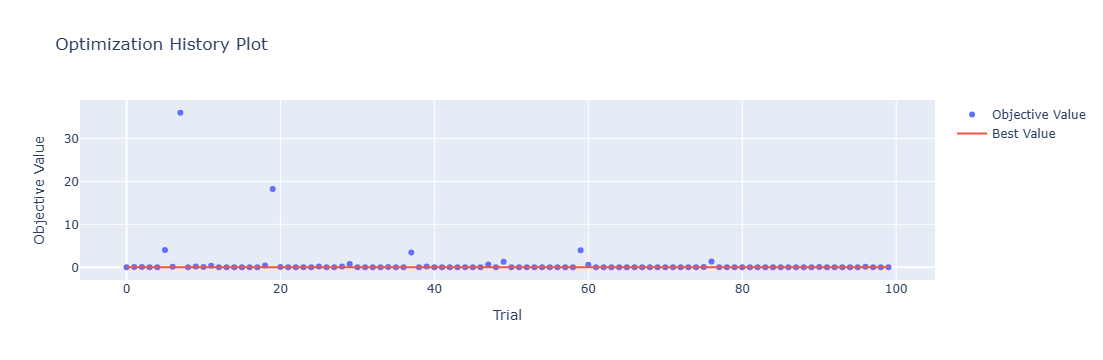

In [4]:
optuna.visualization.plot_optimization_history(study)

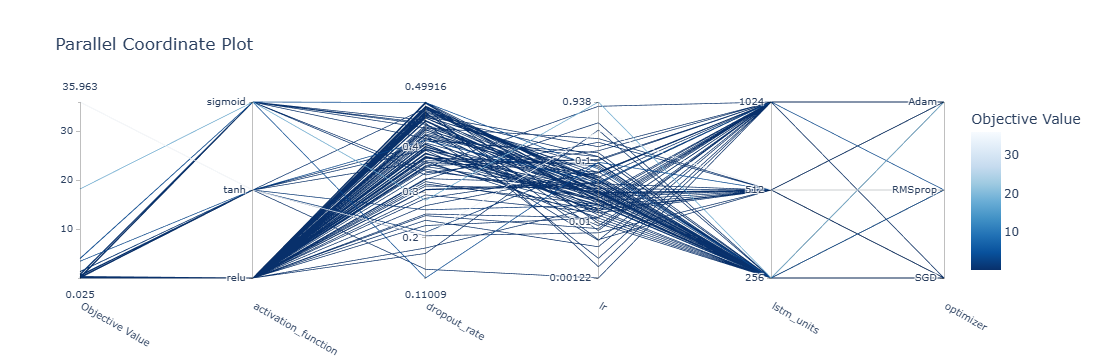

In [5]:
optuna.visualization.plot_parallel_coordinate(study)

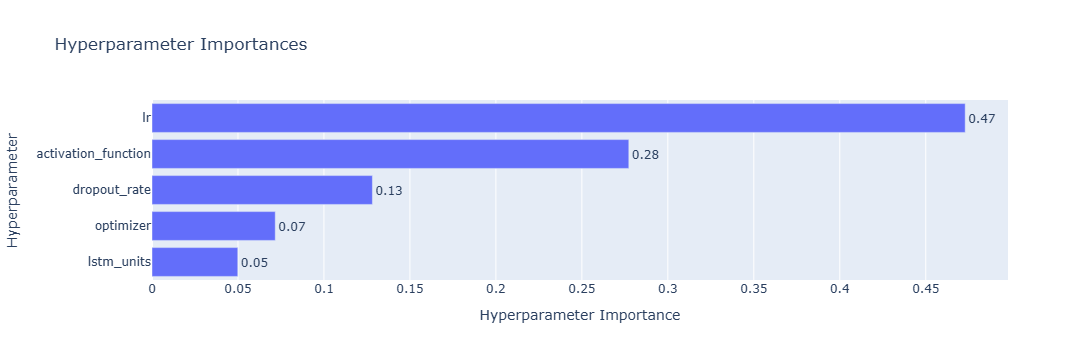

In [6]:
optuna.visualization.plot_param_importances(study)

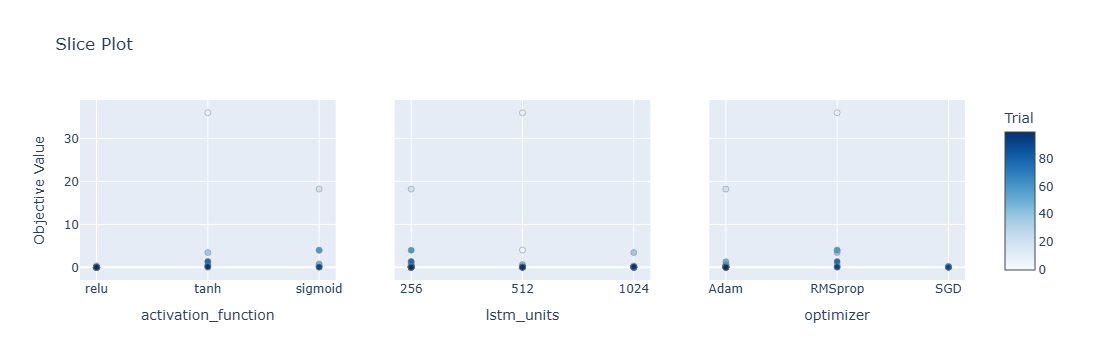

In [7]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

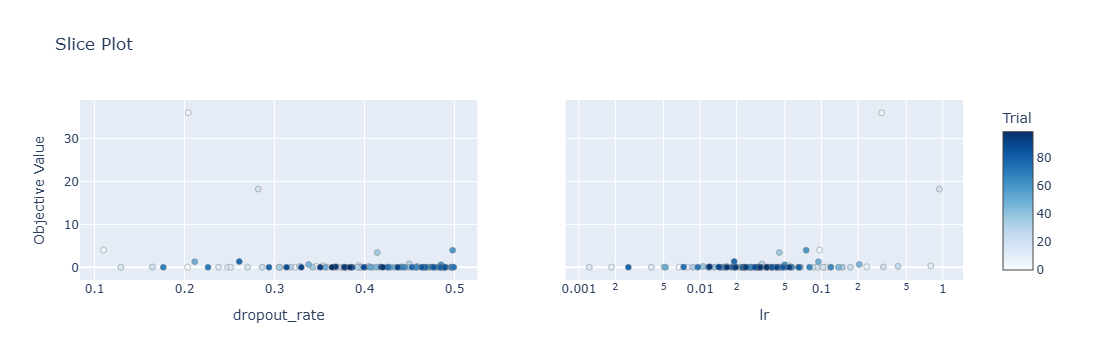

In [8]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate'])

[[ 5.39  4.3   6.51 ... 13.73  8.35  9.05]
 [ 8.03  6.78  8.21 ... 17.14 11.74 12.27]
 [ 5.48  4.27  5.49 ... 13.3   9.17  8.6 ]
 ...
 [ 4.55  3.1   4.22 ... 12.8   7.91  6.65]
 [ 4.44  3.4   5.39 ... 12.34  7.74  6.78]
 [ 4.14  2.75  4.12 ... 10.6   7.07  6.41]]
Epoch 1/100
84/84 [==============================] - 26s 169ms/step - loss: 0.3285 - accuracy: 0.0000e+00 - mae: 0.3285 - rmse: 0.3285 - mape: 68.7212 - pearson: nan - val_loss: 0.0221 - val_accuracy: 0.0000e+00 - val_mae: 0.0221 - val_rmse: 0.0221 - val_mape: 4.6885 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 11s 135ms/step - loss: 0.0394 - accuracy: 0.0000e+00 - mae: 0.0394 - rmse: 0.0394 - mape: 7.9367 - pearson: nan - val_loss: 0.0221 - val_accuracy: 0.0000e+00 - val_mae: 0.0221 - val_rmse: 0.0221 - val_mape: 4.6742 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 10s 119ms/step - loss: 0.0224 - accuracy: 0.0000e+00 - mae: 0.0224 - rmse: 0.0224 - mape: 4.5350 - pearson: na

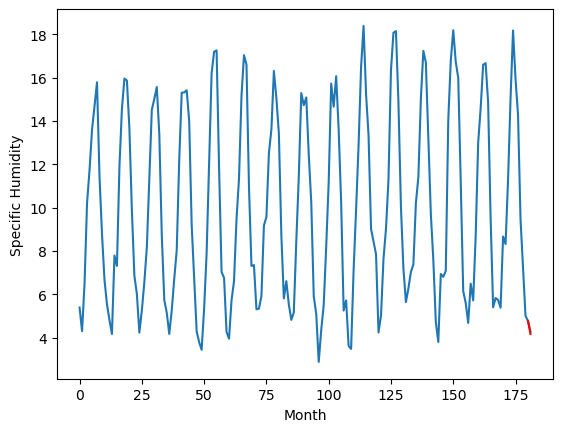

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.74		5.42		-0.32
[180, 181]
[7.05, 5.422550174742937]


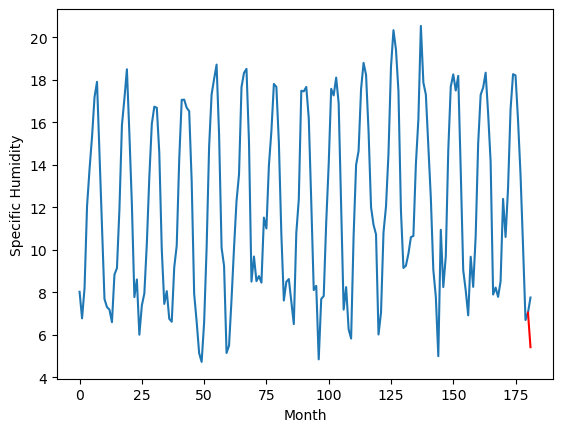

Weather Station 3:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.41		8.06		-0.35
[180, 181]
[5.06, 8.062550174742936]


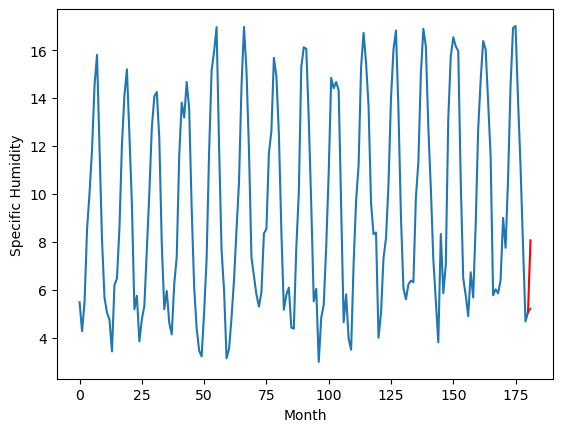

Weather Station 4:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.55		5.51		-0.04
[180, 181]
[7.05, 5.5125501747429375]


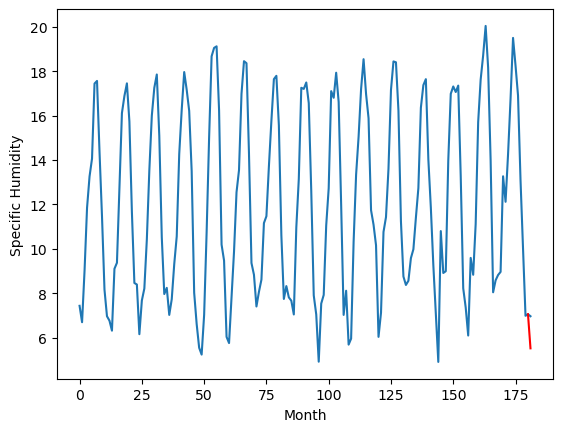

Weather Station 5:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.36		7.46		0.10
[180, 181]
[5.2, 7.462550174742937]


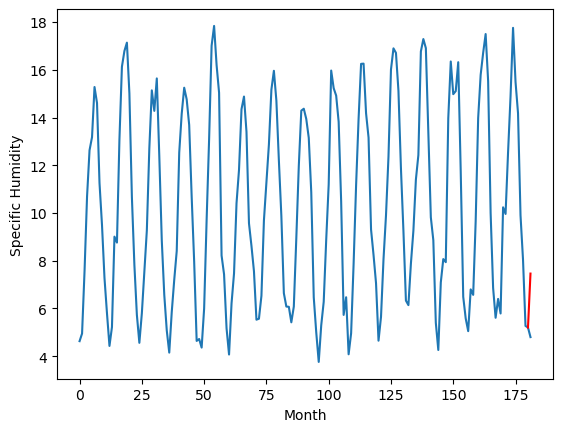

Weather Station 6:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.02		4.66		0.64
[180, 181]
[5.16, 4.662550174742937]


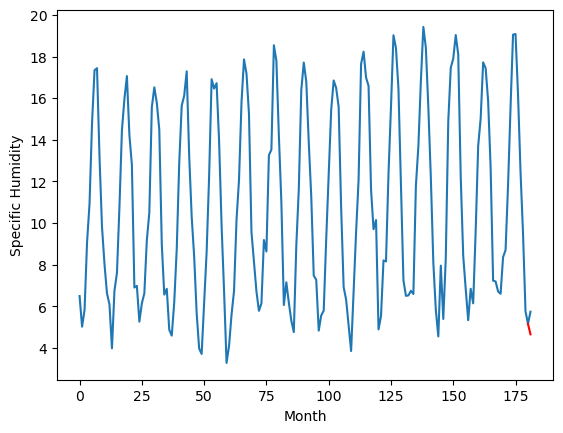

Weather Station 7:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
6.35		6.53		0.18
[180, 181]
[4.05, 6.532550174742937]


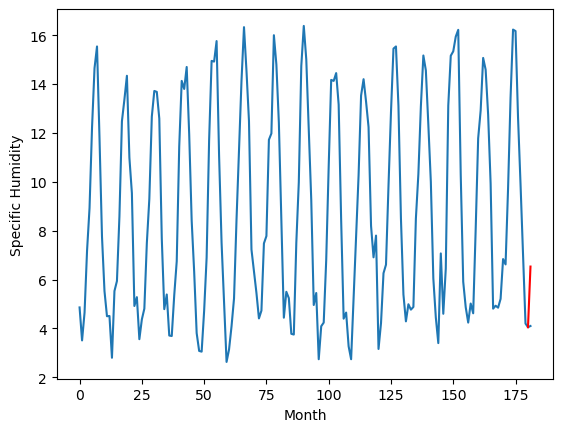

Weather Station 8:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.55		4.89		0.34
[180, 181]
[3.64, 4.892550174742937]


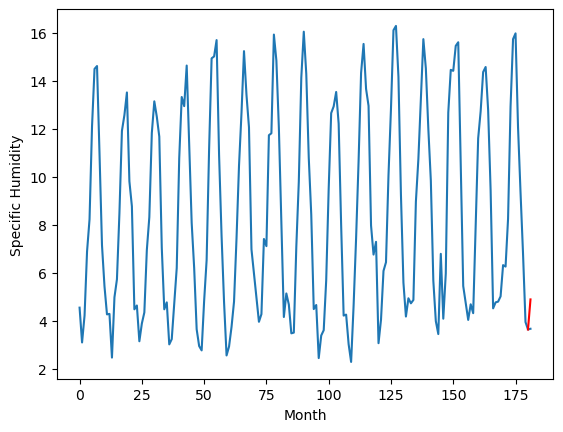

Weather Station 9:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.32		4.58		0.26
[180, 181]
[3.46, 4.582550174742937]


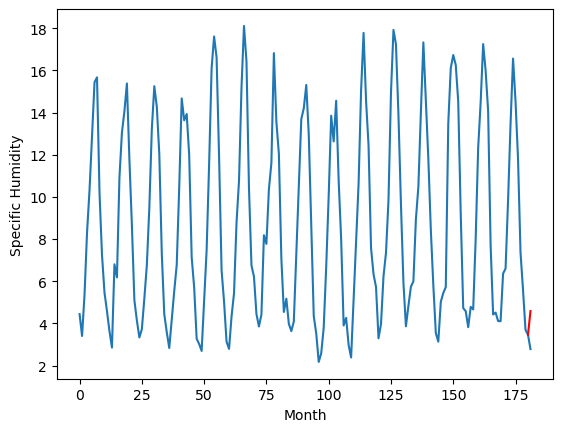

Weather Station 10:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.11		4.47		0.36
[180, 181]
[2.93, 4.4725501747429375]


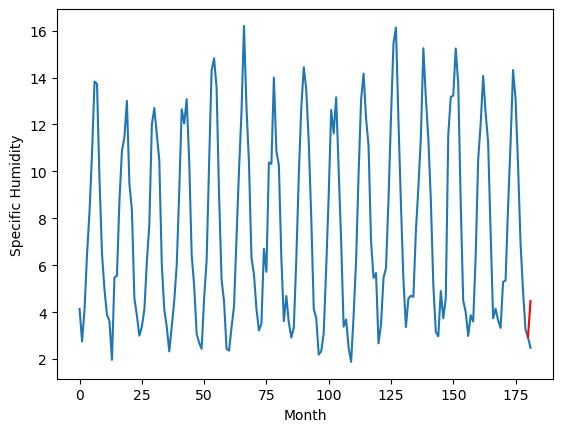

Weather Station 11:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.76		4.17		0.41
[180, 181]
[2.74, 4.172550174742937]


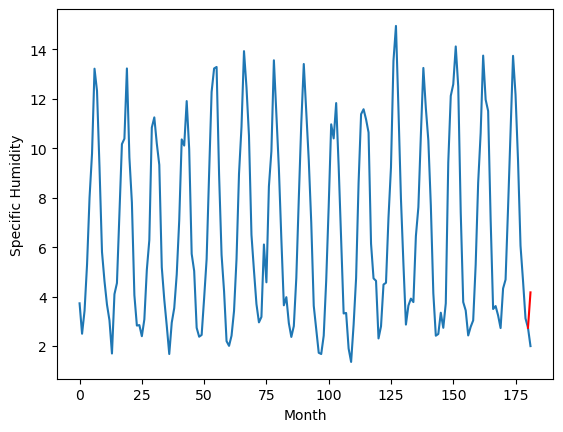

Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    3.90    4.17255
1                 1    5.74    5.42255
2                 2    8.41    8.06255
3                 3    5.55    5.51255
4                 4    7.36    7.46255
5                 5    4.02    4.66255
6                 6    6.35    6.53255
7                 7    4.55    4.89255
8                 8    4.32    4.58255
9                 9    4.11    4.47255
10               10    3.76    4.17255


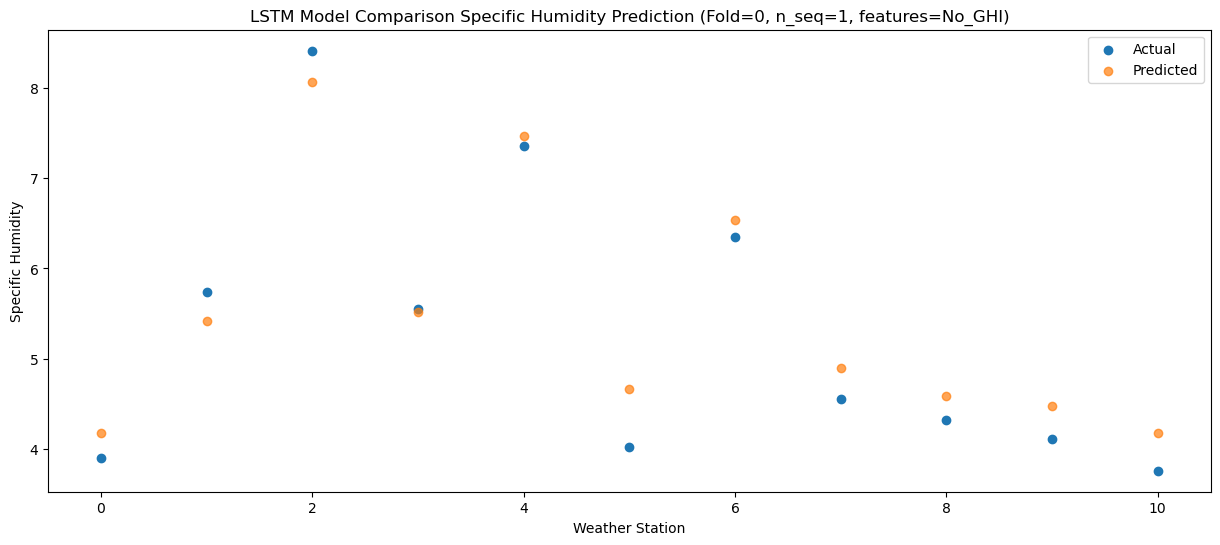

f, t:
[[3.9  5.74 8.41 5.55 7.36 4.02 6.35 4.55 4.32 4.11 3.76]]
[[4.17255017 5.42255017 8.06255017 5.51255017 7.46255017 4.66255017
  6.53255017 4.89255017 4.58255017 4.47255017 4.17255017]]
Year at t+1:
t+1 SKRMSE: 0.335993
t+1 KRMSE: 0.335993
t+1 MAE: 0.298432
t+1 SKMAPE: 0.064524
t+1 R2_SCORE: 0.948640
t+1 KMAPE: 0.064524
t+1 PEARSON: 0.978093
t+1 AVERAGE ACTUAL: 5.279091
Metrics for this Fold:
SKRMSE: 0.335993
KRMSE: 0.335993
MAE: 0.298432
SKMAPE: 0.064524
R2_SCORE: 0.948640
KMAPE: 0.064524
PEARSON: 0.978093
AVERAGE ACTUAL: 5.279091
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, 1, 256)               2279424   
                                                                 
 dropout (Dropout)           (1, 1, 256)               0         
                                                                 
 lstm_1 (LSTM)               (1, 256)   

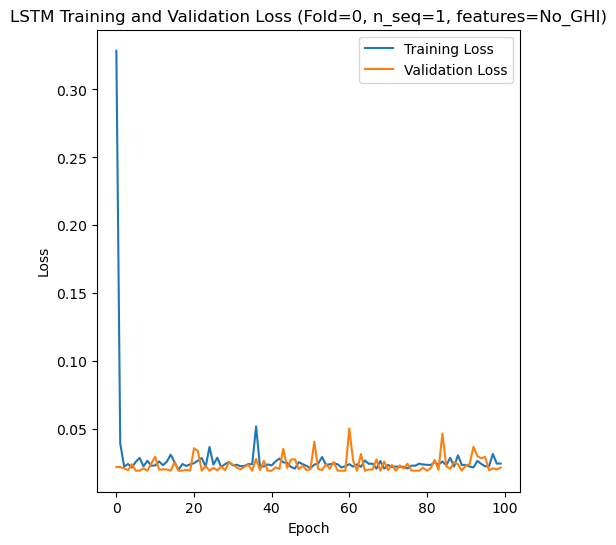

[[ 6.43  5.26  5.95 ... 15.04 10.09  9.76]
 [ 4.92  3.81  4.91 ... 12.52  8.69  7.9 ]
 [ 5.77  4.38  5.81 ... 14.28  9.78  9.52]
 ...
 [ 4.32  3.52  5.54 ... 12.    6.96  7.01]
 [ 3.07  3.12  5.08 ... 11.47  8.11  7.14]
 [ 2.37  2.06  3.5  ...  9.32  6.33  5.39]]
Epoch 1/100
84/84 [==============================] - 40s 240ms/step - loss: 0.2852 - accuracy: 0.0000e+00 - mae: 0.2852 - rmse: 0.2852 - mape: 58.0904 - pearson: nan - val_loss: 0.0197 - val_accuracy: 0.0000e+00 - val_mae: 0.0197 - val_rmse: 0.0197 - val_mape: 4.1518 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 13s 153ms/step - loss: 0.0598 - accuracy: 0.0000e+00 - mae: 0.0598 - rmse: 0.0598 - mape: 12.1190 - pearson: nan - val_loss: 0.0747 - val_accuracy: 0.0000e+00 - val_mae: 0.0747 - val_rmse: 0.0747 - val_mape: 15.1856 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 13s 158ms/step - loss: 0.0289 - accuracy: 0.0000e+00 - mae: 0.0289 - rmse: 0.0289 - mape: 5.8648 - pearson: 

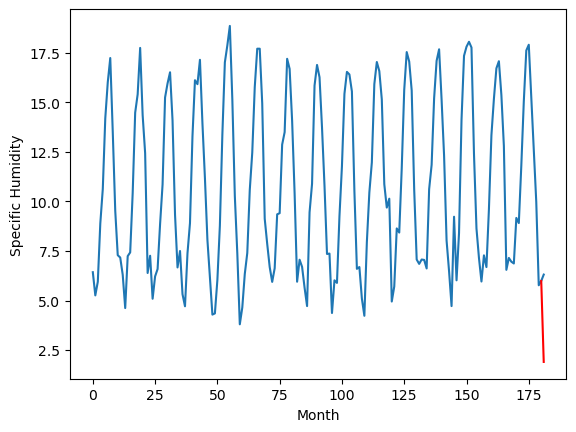

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
6.45		5.96		-0.49
[180, 181]
[4.15, 5.961716167926788]


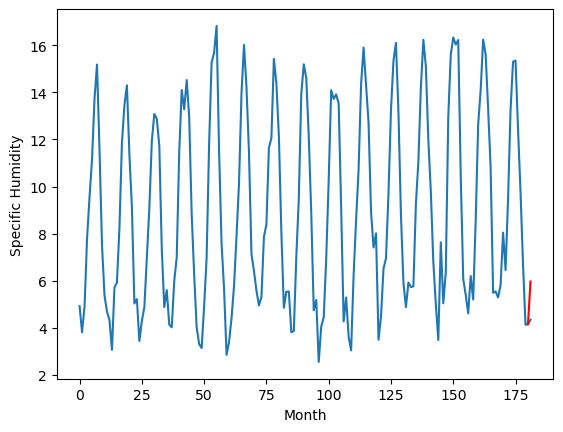

Weather Station 3:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.07		4.45		-0.62
[180, 181]
[5.12, 4.451716167926788]


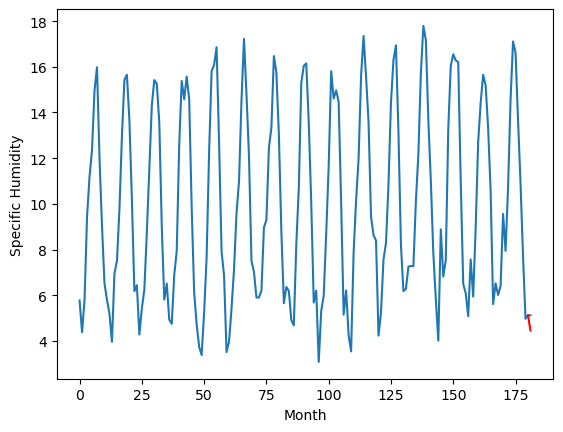

Weather Station 4:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.43		5.30		-0.13
[180, 181]
[6.35, 5.301716167926788]


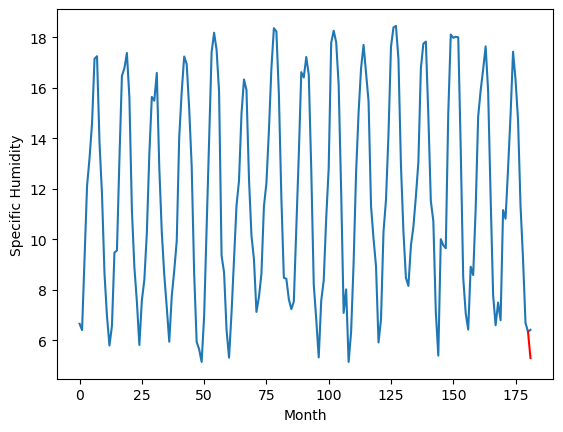

Weather Station 5:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
6.41		6.19		-0.22
[180, 181]
[6.08, 6.1917161679267885]


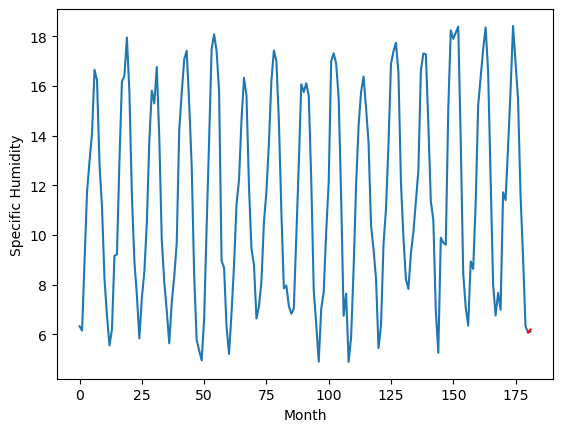

Weather Station 6:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.16		5.86		-1.30
[180, 181]
[3.92, 5.861716167926788]


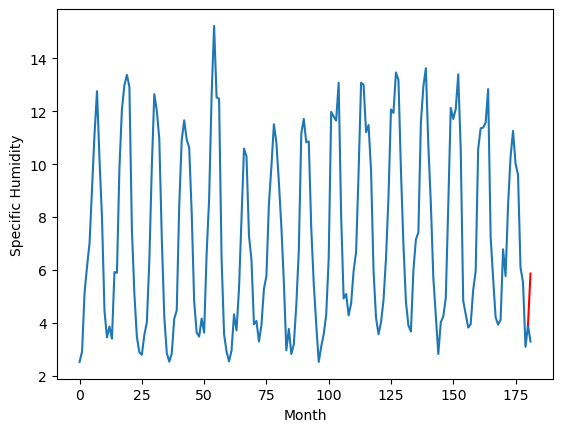

Weather Station 7:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
2.41		2.05		-0.36
[180, 181]
[4.16, 2.0517161679267883]


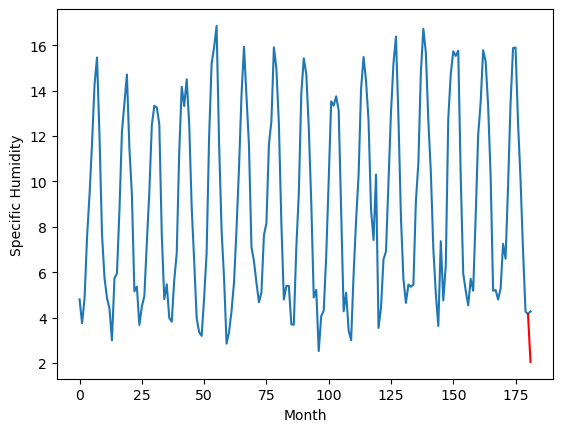

Weather Station 8:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.68		4.34		-0.34
[180, 181]
[3.84, 4.341716167926788]


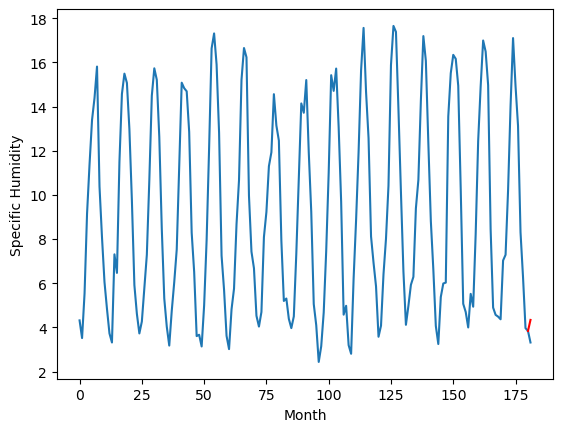

Weather Station 9:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.48		3.85		-0.63
[180, 181]
[3.73, 3.8517161679267886]


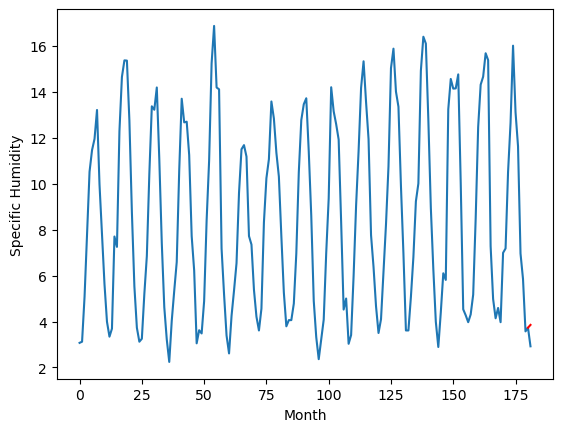

Weather Station 10:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.26		2.60		-0.66
[180, 181]
[2.83, 2.601716167926788]


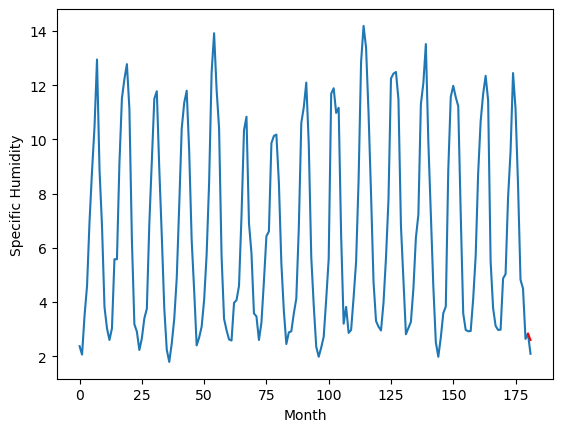

Weather Station 11:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
1.64		1.90		0.26
[180, 181]
[2.69, 1.9017161679267884]


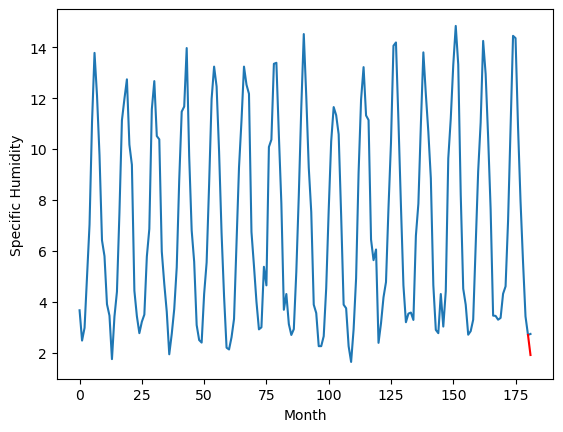

Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    2.59   1.901716
1                 1    6.45   5.961716
2                 2    5.07   4.451716
3                 3    5.43   5.301716
4                 4    6.41   6.191716
5                 5    7.16   5.861716
6                 6    2.41   2.051716
7                 7    4.68   4.341716
8                 8    4.48   3.851716
9                 9    3.26   2.601716
10               10    1.64   1.901716


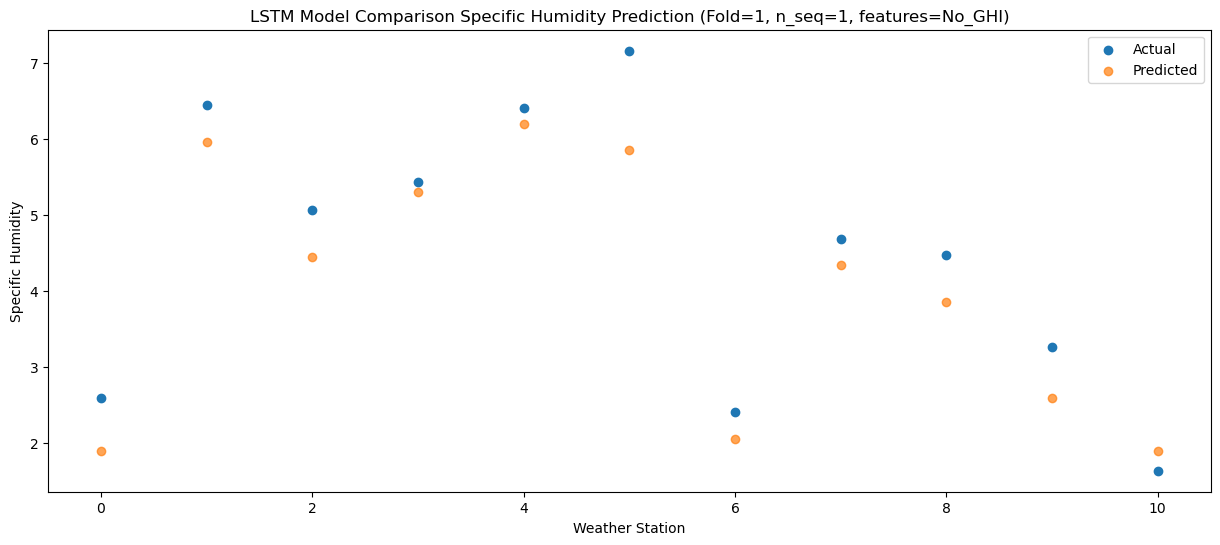

f, t:
[[2.59 6.45 5.07 5.43 6.41 7.16 2.41 4.68 4.48 3.26 1.64]]
[[1.90171617 5.96171617 4.45171617 5.30171617 6.19171617 5.86171617
  2.05171617 4.34171617 3.85171617 2.60171617 1.90171617]]
Year at t+1:
t+1 SKRMSE: 0.601774
t+1 KRMSE: 0.601774
t+1 MAE: 0.516778
t+1 SKMAPE: 0.129555
t+1 R2_SCORE: 0.881026
t+1 KMAPE: 0.129555
t+1 PEARSON: 0.956055
t+1 AVERAGE ACTUAL: 4.507273
Metrics for this Fold:
SKRMSE: 0.601774
KRMSE: 0.601774
MAE: 0.516778
SKMAPE: 0.129555
R2_SCORE: 0.881026
KMAPE: 0.129555
PEARSON: 0.956055
AVERAGE ACTUAL: 4.507273
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (1, 1, 256)               2279424   
                                                                 
 dropout_2 (Dropout)         (1, 1, 256)               0         
                                                                 
 lstm_3 (LSTM)               (1, 256) 

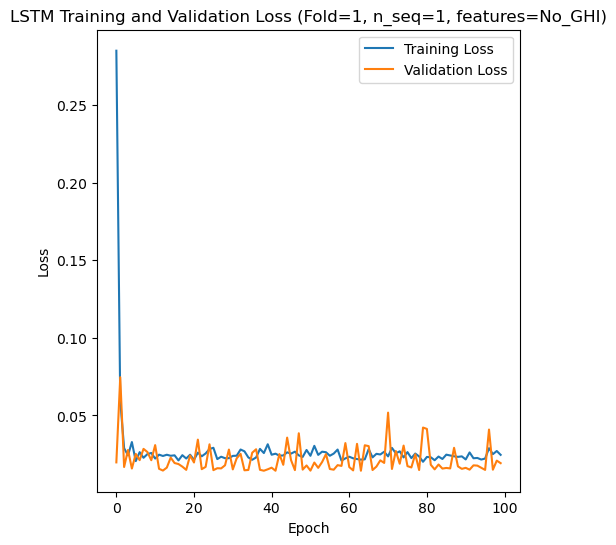

[[ 4.97  3.84  5.83 ... 12.86  8.48  8.25]
 [ 2.46  2.06  3.48 ...  9.57  6.71  5.1 ]
 [ 8.78  8.15  9.01 ... 20.36 15.38 12.95]
 ...
 [ 1.89  2.51  2.73 ...  7.42  4.53  3.35]
 [ 5.04  4.9   5.93 ... 10.09  8.19  4.88]
 [ 5.06  3.79  4.84 ... 13.58  8.96  7.8 ]]
Epoch 1/100
84/84 [==============================] - 46s 231ms/step - loss: 0.3840 - accuracy: 0.0000e+00 - mae: 0.3840 - rmse: 0.3840 - mape: 76.3518 - pearson: nan - val_loss: 0.0568 - val_accuracy: 0.0000e+00 - val_mae: 0.0568 - val_rmse: 0.0568 - val_mape: 11.7090 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 13s 157ms/step - loss: 0.0589 - accuracy: 0.0000e+00 - mae: 0.0589 - rmse: 0.0589 - mape: 11.7295 - pearson: nan - val_loss: 0.0550 - val_accuracy: 0.0000e+00 - val_mae: 0.0550 - val_rmse: 0.0550 - val_mape: 11.6632 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 13s 160ms/step - loss: 0.0263 - accuracy: 0.0000e+00 - mae: 0.0263 - rmse: 0.0263 - mape: 5.2656 - pearson:

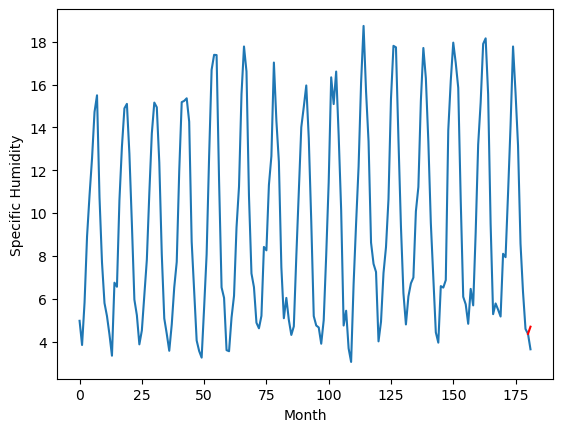

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.92		4.61		-0.31
[180, 181]
[2.82, 4.605353475809097]


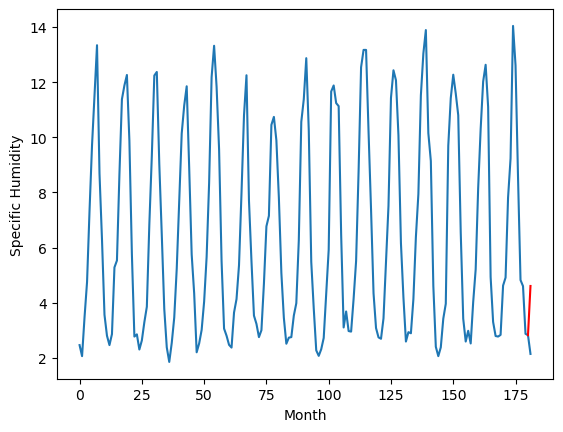

Weather Station 3:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
2.95		2.10		-0.85
[180, 181]
[9.16, 2.0953534758090973]


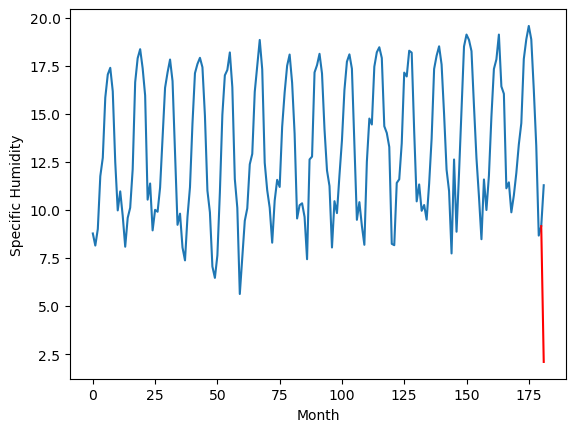

Weather Station 4:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.70		8.42		0.72
[180, 181]
[2.44, 8.415353475809097]


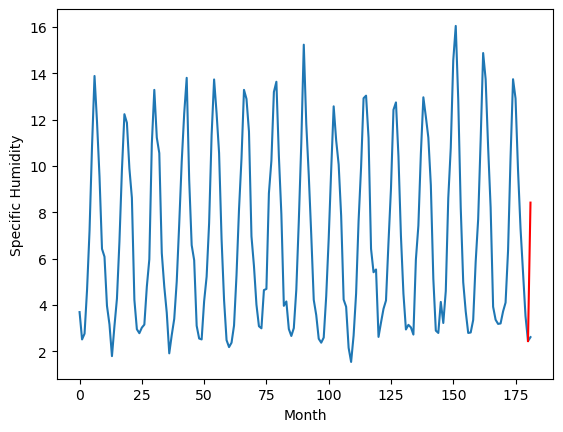

Weather Station 5:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.82		3.33		-0.49
[180, 181]
[6.65, 3.3253534758090972]


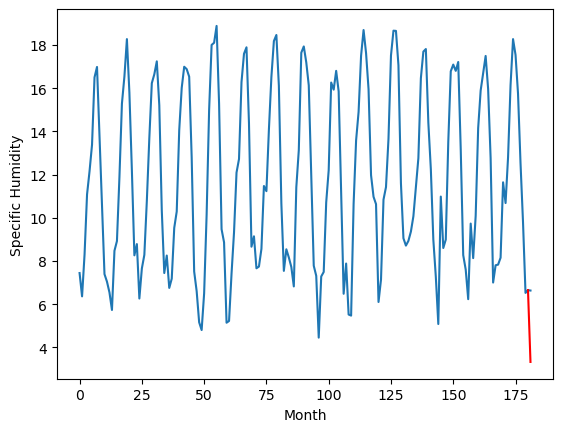

Weather Station 6:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.31		7.08		-0.23
[180, 181]
[6.19, 7.075353475809098]


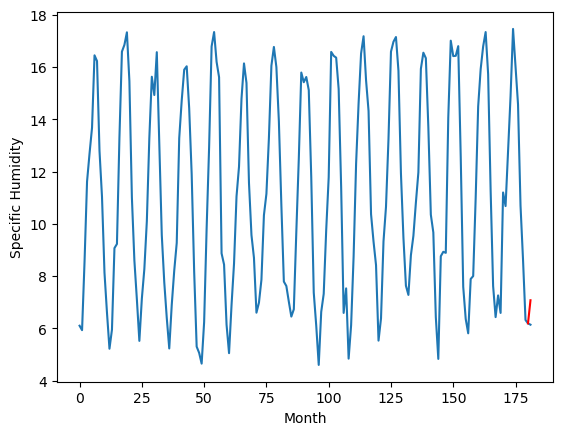

Weather Station 7:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
6.00		5.74		-0.26
[180, 181]
[4.78, 5.735353475809097]


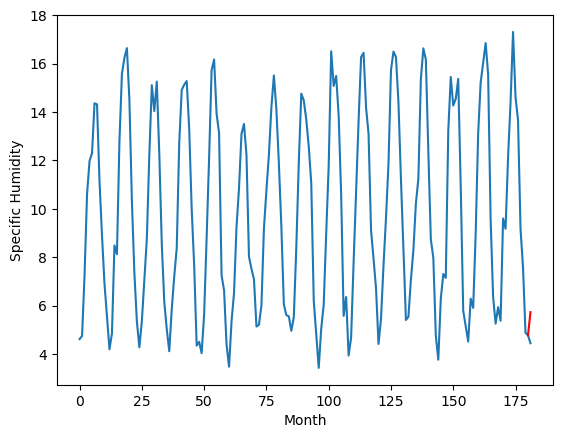

Weather Station 8:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.90		4.26		-0.64
[180, 181]
[2.61, 4.255353475809097]


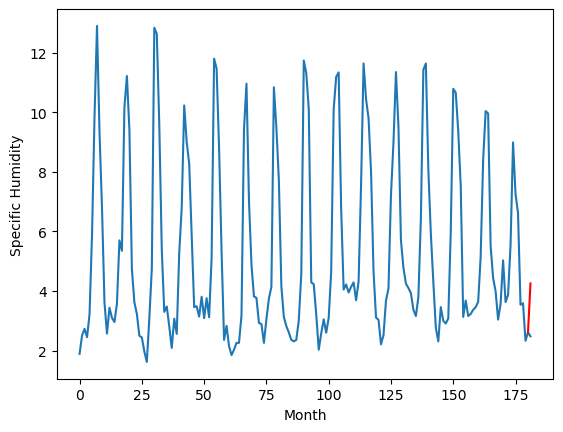

Weather Station 9:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
2.74		1.53		-1.21
[180, 181]
[4.6, 1.5253534758090972]


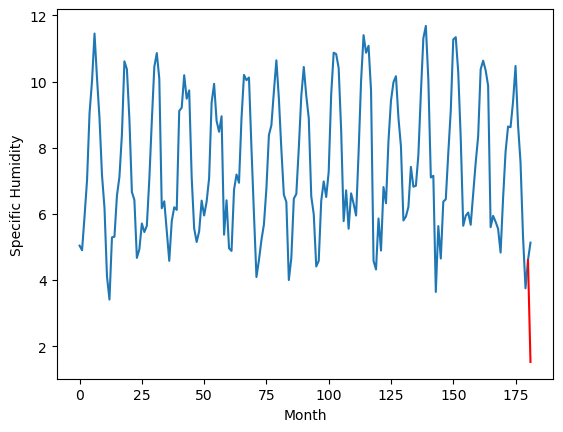

Weather Station 10:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.92		4.68		-0.24
[180, 181]
[4.27, 4.675353475809097]


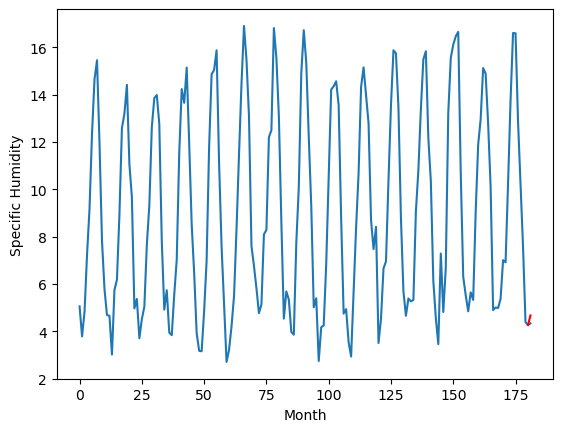

Weather Station 11:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.07		4.70		-0.37
[180, 181]
[3.91, 4.695353475809097]


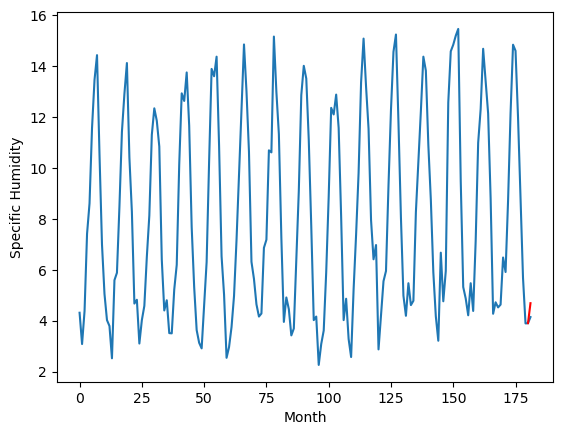

Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    4.83   4.695353
1                 1    4.92   4.605353
2                 2    2.95   2.095353
3                 3    7.70   8.415353
4                 4    3.82   3.325353
5                 5    7.31   7.075353
6                 6    6.00   5.735353
7                 7    4.90   4.255353
8                 8    2.74   1.525353
9                 9    4.92   4.675353
10               10    5.07   4.695353


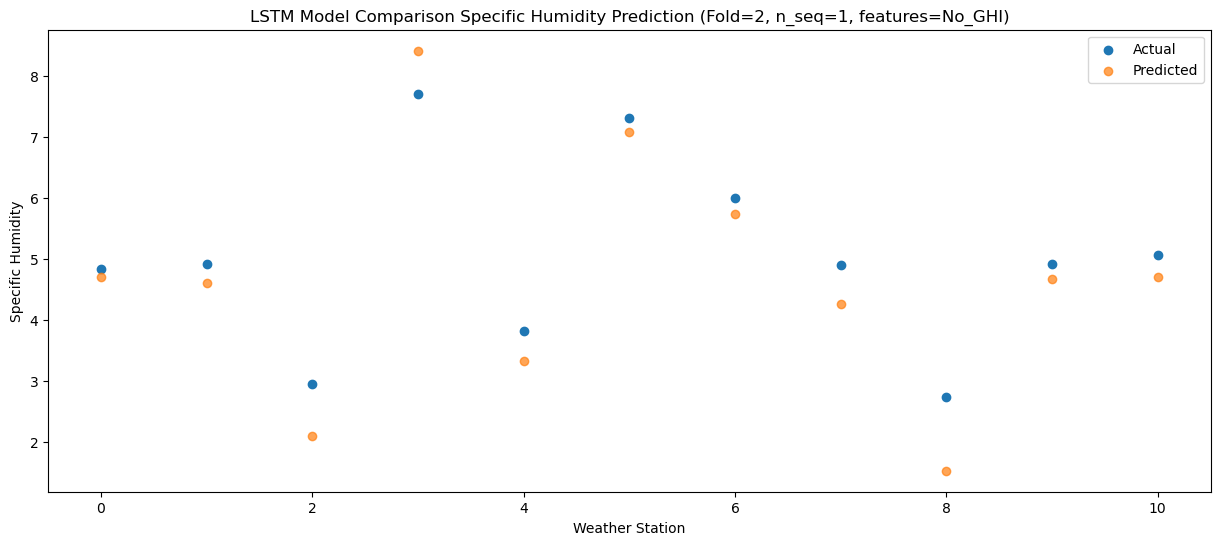

f, t:
[[4.83 4.92 2.95 7.7  3.82 7.31 6.   4.9  2.74 4.92 5.07]]
[[4.69535348 4.60535348 2.09535348 8.41535348 3.32535348 7.07535348
  5.73535348 4.25535348 1.52535348 4.67535348 4.69535348]]
Year at t+1:
t+1 SKRMSE: 0.589314
t+1 KRMSE: 0.589314
t+1 MAE: 0.499256
t+1 SKMAPE: 0.125329
t+1 R2_SCORE: 0.843324
t+1 KMAPE: 0.125329
t+1 PEARSON: 0.983358
t+1 AVERAGE ACTUAL: 5.014545
Metrics for this Fold:
SKRMSE: 0.589314
KRMSE: 0.589314
MAE: 0.499256
SKMAPE: 0.125329
R2_SCORE: 0.843324
KMAPE: 0.125329
PEARSON: 0.983358
AVERAGE ACTUAL: 5.014545
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (1, 1, 256)               2279424   
                                                                 
 dropout_4 (Dropout)         (1, 1, 256)               0         
                                                                 
 lstm_5 (LSTM)               (1, 256) 

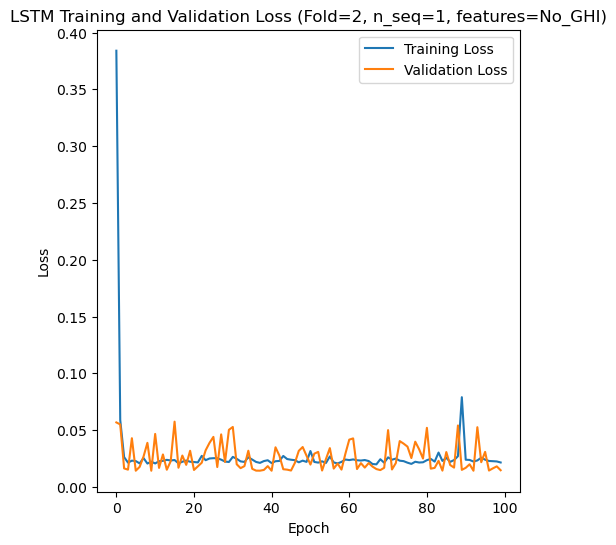

[[ 5.11  3.7   4.74 ... 13.5   8.68  7.66]
 [ 3.73  2.91  5.05 ... 11.19  6.96  6.57]
 [ 5.56  5.41  5.55 ...  8.56  7.45  5.59]
 ...
 [ 2.73  2.21  3.23 ...  5.    3.95  3.09]
 [ 5.93  5.59  5.49 ...  8.63  7.04  6.11]
 [ 3.71  2.55  2.84 ...  9.78  6.68  4.77]]
Epoch 1/100
84/84 [==============================] - 46s 243ms/step - loss: 0.3528 - accuracy: 0.0000e+00 - mae: 0.3528 - rmse: 0.3528 - mape: 71.3993 - pearson: nan - val_loss: 0.0190 - val_accuracy: 0.0000e+00 - val_mae: 0.0190 - val_rmse: 0.0190 - val_mape: 3.7238 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 13s 153ms/step - loss: 0.0388 - accuracy: 0.0000e+00 - mae: 0.0388 - rmse: 0.0388 - mape: 7.8483 - pearson: nan - val_loss: 0.0331 - val_accuracy: 0.0000e+00 - val_mae: 0.0331 - val_rmse: 0.0331 - val_mape: 6.6957 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 13s 150ms/step - loss: 0.0253 - accuracy: 0.0000e+00 - mae: 0.0253 - rmse: 0.0253 - mape: 5.1367 - pearson: na

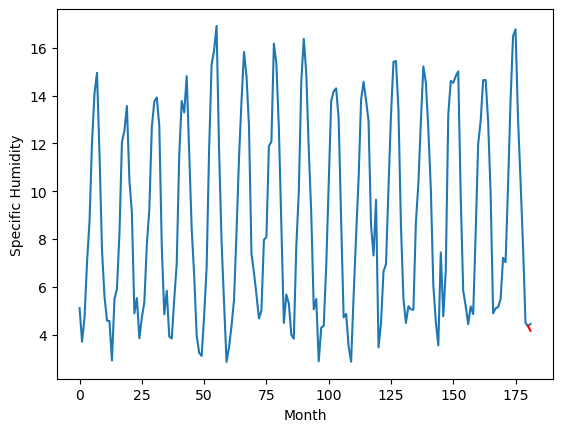

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.02		5.56		0.54
[180, 181]
[3.43, 5.558418587446213]


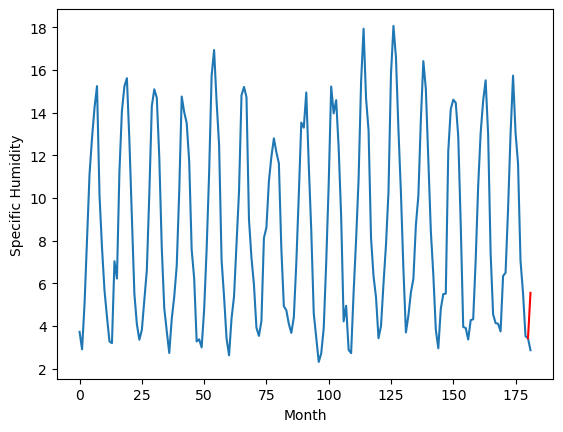

Weather Station 3:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.17		4.18		0.01
[180, 181]
[5.43, 4.178418587446213]


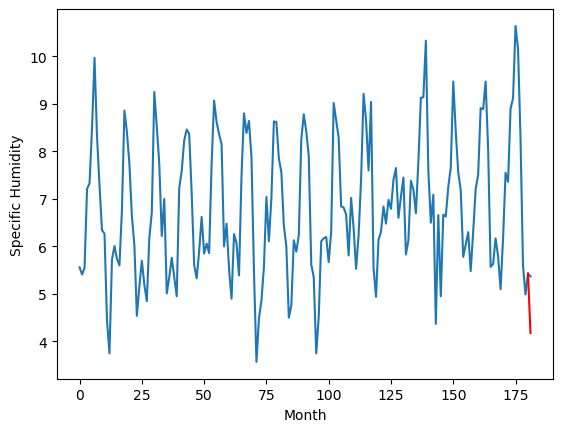

Weather Station 4:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.29		6.01		0.72
[180, 181]
[3.21, 6.008418587446212]


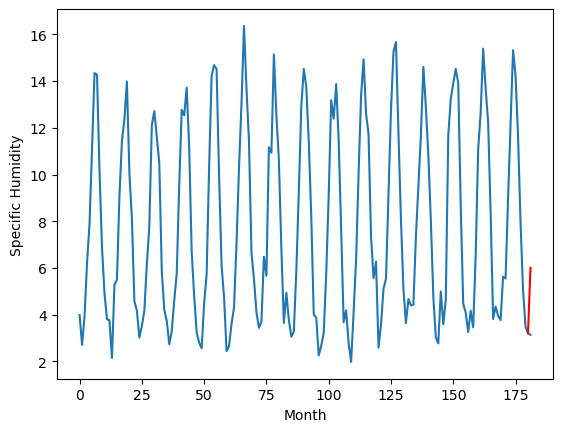

Weather Station 5:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.79		4.44		0.65
[180, 181]
[3.04, 4.438418587446213]


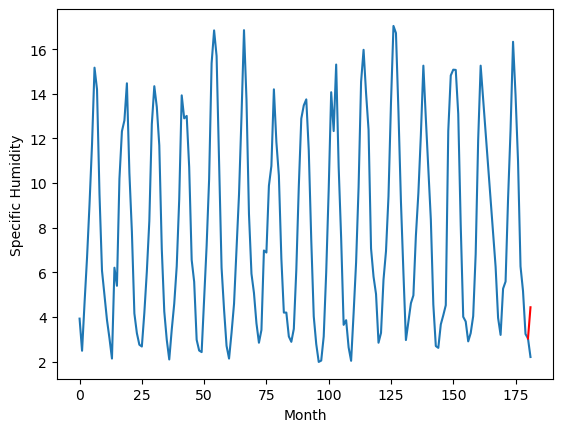

Weather Station 6:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.62		4.38		0.76
[180, 181]
[2.91, 4.3784185874462125]


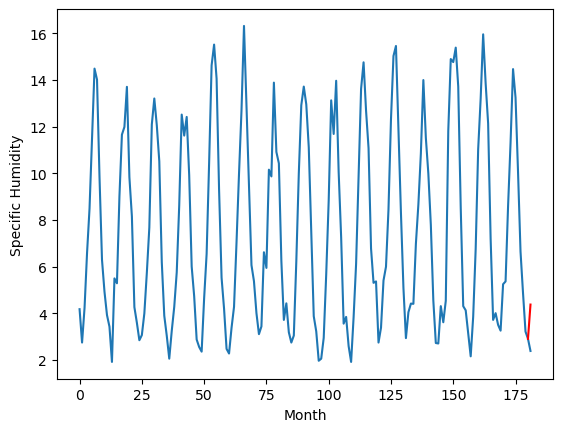

Weather Station 7:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.35		4.63		0.28
[180, 181]
[1.6, 4.6284185874462125]


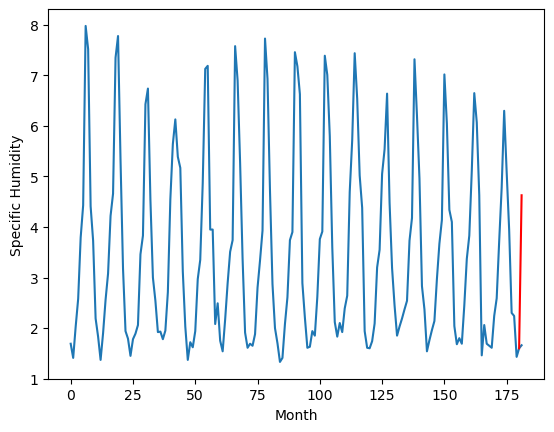

Weather Station 8:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
2.50		2.14		-0.36
[180, 181]
[2.86, 2.1384185874462127]


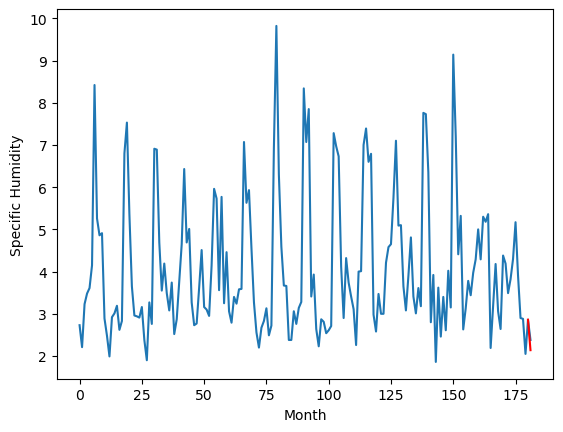

Weather Station 9:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.40		3.18		-0.22
[180, 181]
[5.65, 3.1784185874462128]


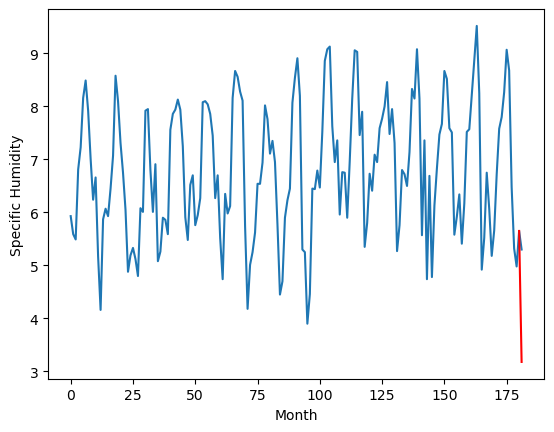

Weather Station 10:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.84		6.38		1.54
[180, 181]
[2.54, 6.3784185874462125]


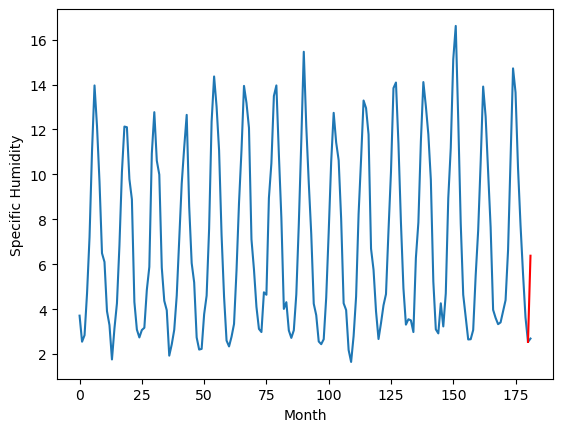

Weather Station 11:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.02		4.16		1.14
[180, 181]
[2.51, 4.158418587446213]


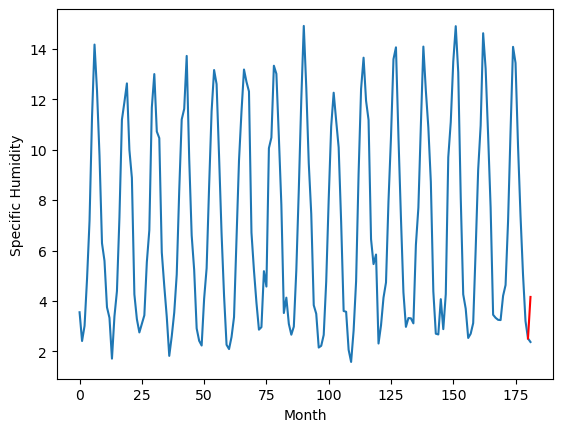

Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    3.58   4.158419
1                 1    5.02   5.558419
2                 2    4.17   4.178419
3                 3    5.29   6.008419
4                 4    3.79   4.438419
5                 5    3.62   4.378419
6                 6    4.35   4.628419
7                 7    2.50   2.138419
8                 8    3.40   3.178419
9                 9    4.84   6.378419
10               10    3.02   4.158419


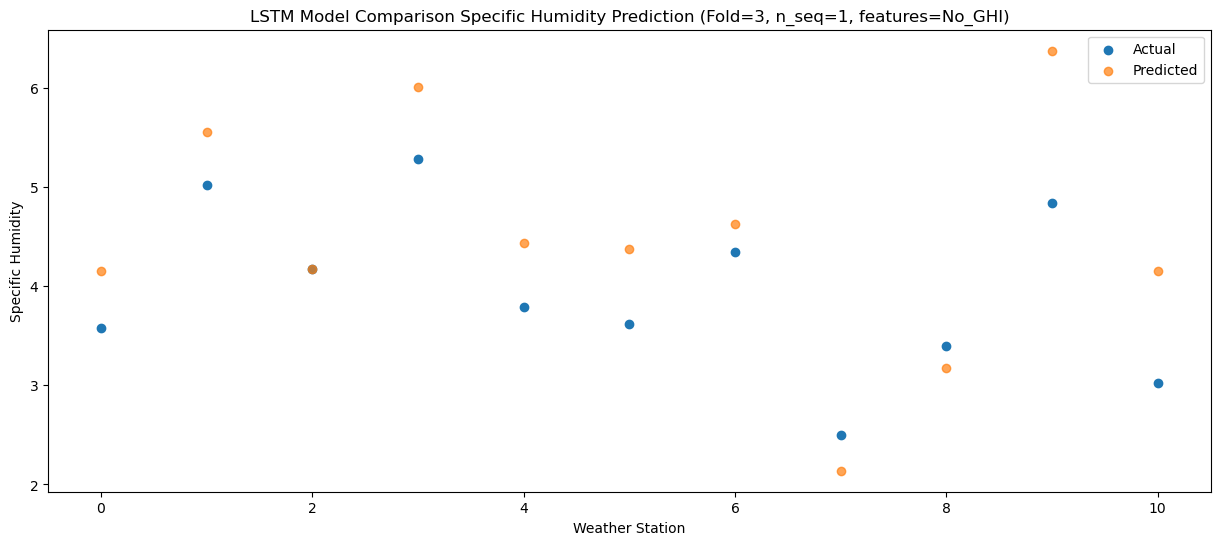

f, t:
[[3.58 5.02 4.17 5.29 3.79 3.62 4.35 2.5  3.4  4.84 3.02]]
[[4.15841859 5.55841859 4.17841859 6.00841859 4.43841859 4.37841859
  4.62841859 2.13841859 3.17841859 6.37841859 4.15841859]]
Year at t+1:
t+1 SKRMSE: 0.742011
t+1 KRMSE: 0.742011
t+1 MAE: 0.617175
t+1 SKMAPE: 0.159624
t+1 R2_SCORE: 0.190405
t+1 KMAPE: 0.159624
t+1 PEARSON: 0.817852
t+1 AVERAGE ACTUAL: 3.961818
Metrics for this Fold:
SKRMSE: 0.742011
KRMSE: 0.742011
MAE: 0.617175
SKMAPE: 0.159624
R2_SCORE: 0.190405
KMAPE: 0.159624
PEARSON: 0.817852
AVERAGE ACTUAL: 3.961818
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (1, 1, 256)               2279424   
                                                                 
 dropout_6 (Dropout)         (1, 1, 256)               0         
                                                                 
 lstm_7 (LSTM)               (1, 256) 

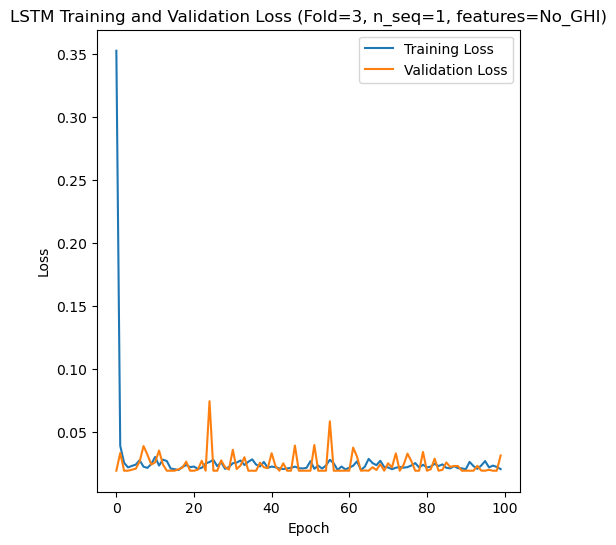

[[ 3.4   2.19  4.28 ... 10.54  6.41  5.39]
 [ 7.94  7.22  7.86 ... 18.27 13.85 11.85]
 [ 5.92  4.91  6.84 ... 14.38  9.59 10.48]
 ...
 [ 3.92  3.    4.93 ... 11.51  7.19  6.46]
 [ 3.98  2.61  4.   ... 10.23  6.65  5.8 ]
 [ 3.84  2.35  4.25 ... 10.6   6.5   5.9 ]]
Epoch 1/100
84/84 [==============================] - 46s 237ms/step - loss: 0.5124 - accuracy: 0.0000e+00 - mae: 0.5124 - rmse: 0.5124 - mape: 106.1139 - pearson: nan - val_loss: 0.0208 - val_accuracy: 0.0000e+00 - val_mae: 0.0208 - val_rmse: 0.0208 - val_mape: 4.1524 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 13s 154ms/step - loss: 0.0562 - accuracy: 0.0000e+00 - mae: 0.0562 - rmse: 0.0562 - mape: 11.3574 - pearson: nan - val_loss: 0.0208 - val_accuracy: 0.0000e+00 - val_mae: 0.0208 - val_rmse: 0.0208 - val_mape: 4.1247 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 13s 153ms/step - loss: 0.0244 - accuracy: 0.0000e+00 - mae: 0.0244 - rmse: 0.0244 - mape: 4.8802 - pearson: 

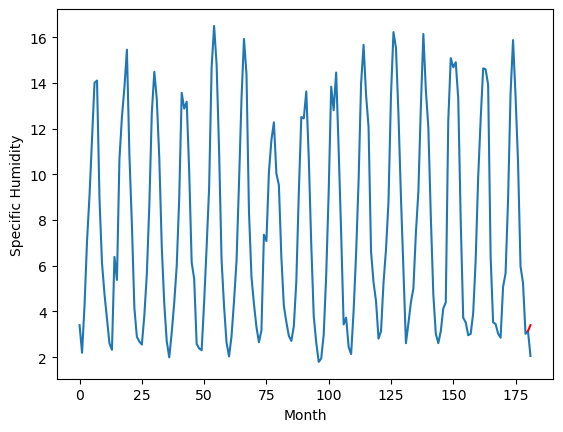

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.75		2.96		-0.79
[180, 181]
[7.79, 2.959432029724121]


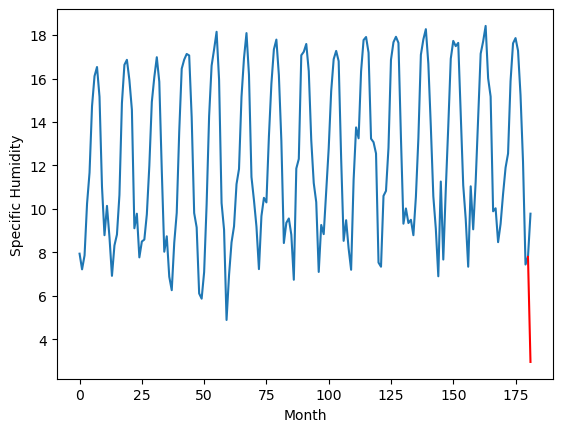

Weather Station 3:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.83		7.50		-0.33
[180, 181]
[5.03, 7.4994320297241215]


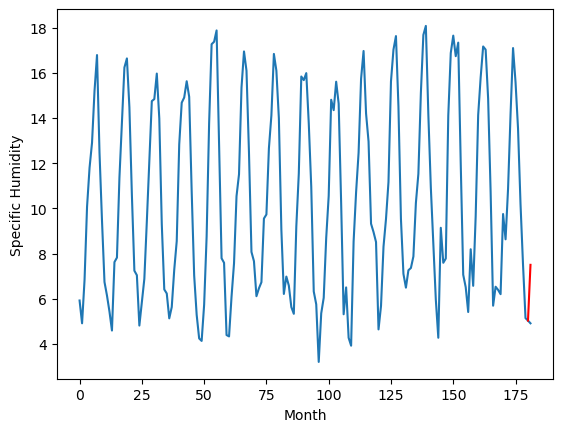

Weather Station 4:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.81		5.48		-0.33
[180, 181]
[4.41, 5.479432029724121]


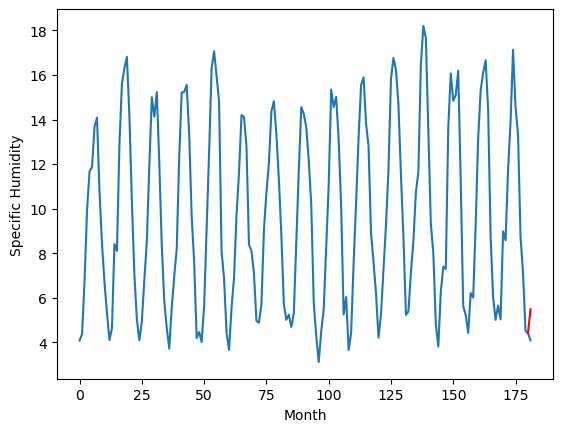

Weather Station 5:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.04		3.64		-0.40
[180, 181]
[4.29, 3.639432029724121]


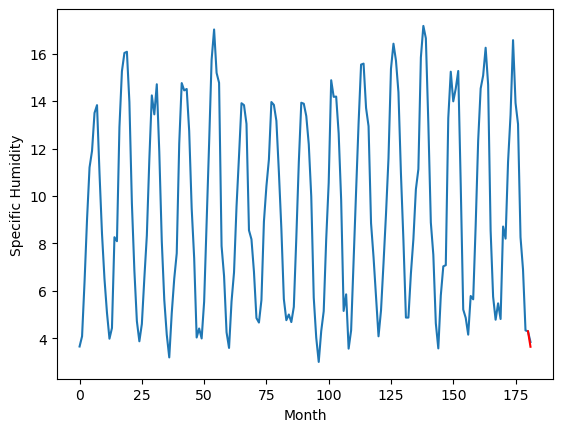

Weather Station 6:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.35		3.21		-1.14
[180, 181]
[3.47, 3.209432029724121]


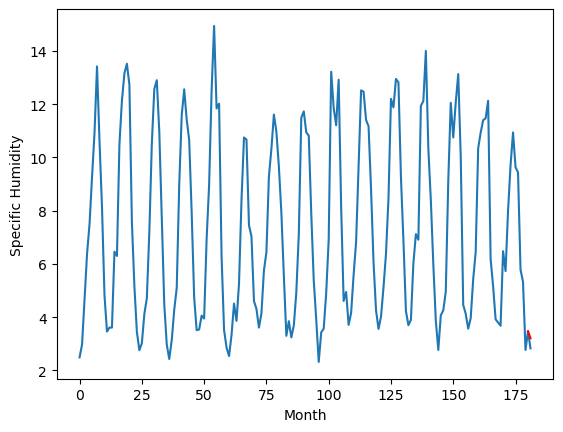

Weather Station 7:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
2.37		2.05		-0.32
[180, 181]
[4.52, 2.0494320297241213]


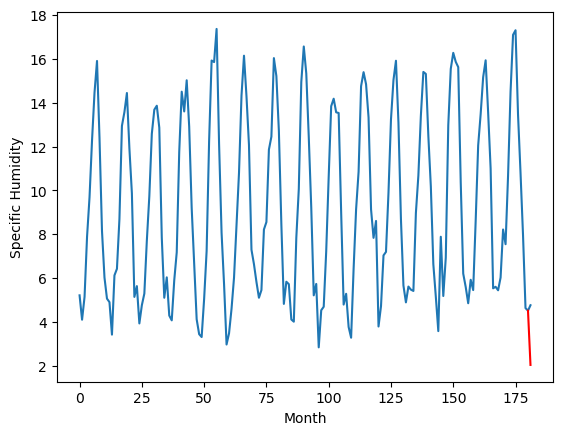

Weather Station 8:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.07		4.78		-0.29
[180, 181]
[3.4, 4.779432029724121]


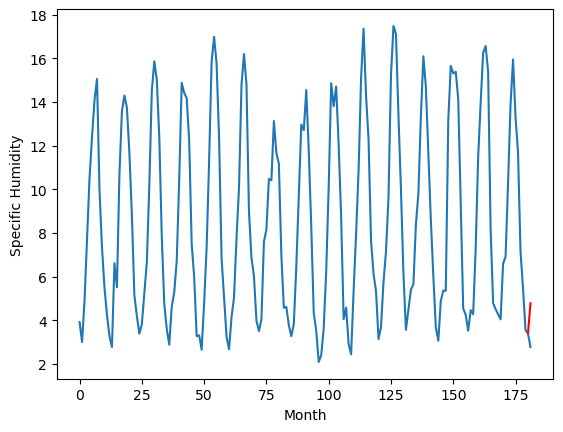

Weather Station 9:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.57		3.48		-0.09
[180, 181]
[2.82, 3.479432029724121]


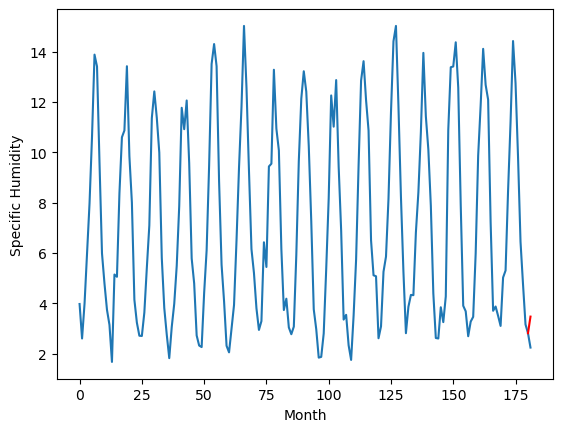

Weather Station 10:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.66		3.54		-0.12
[180, 181]
[2.86, 3.539432029724121]


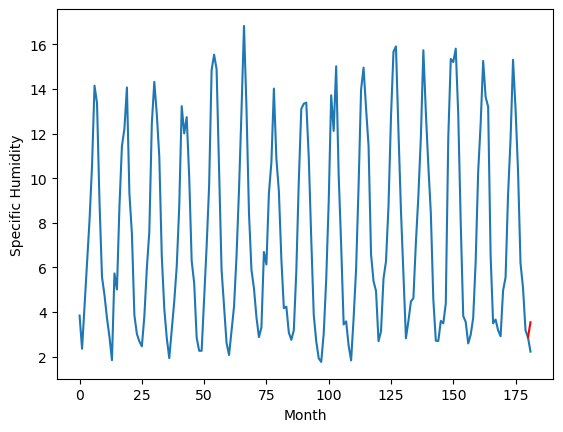

Weather Station 11:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.46		3.40		-0.06
[180, 181]
[2.61, 3.399432029724121]


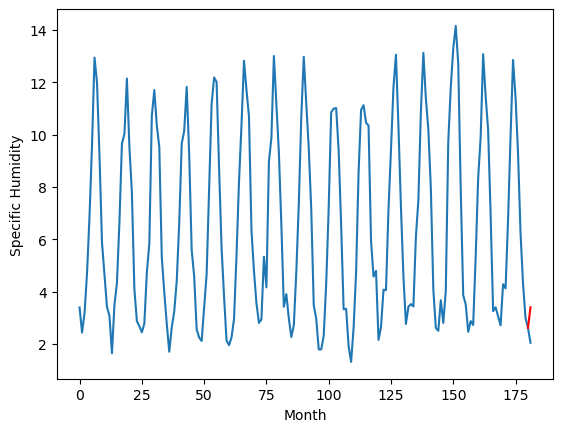

Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    3.96   3.399432
1                 1    3.75   2.959432
2                 2    7.83   7.499432
3                 3    5.81   5.479432
4                 4    4.04   3.639432
5                 5    4.35   3.209432
6                 6    2.37   2.049432
7                 7    5.07   4.779432
8                 8    3.57   3.479432
9                 9    3.66   3.539432
10               10    3.46   3.399432


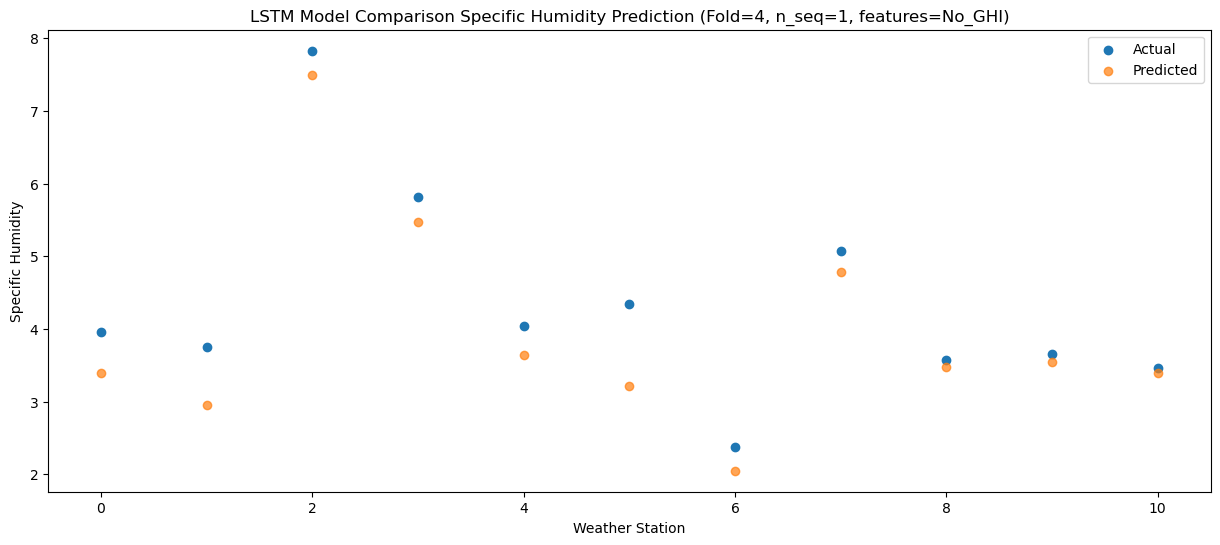

f, t:
[[3.96 3.75 7.83 5.81 4.04 4.35 2.37 5.07 3.57 3.66 3.46]]
[[3.39943203 2.95943203 7.49943203 5.47943203 3.63943203 3.20943203
  2.04943203 4.77943203 3.47943203 3.53943203 3.39943203]]
Year at t+1:
t+1 SKRMSE: 0.507466
t+1 KRMSE: 0.507466
t+1 MAE: 0.403295
t+1 SKMAPE: 0.098294
t+1 R2_SCORE: 0.866163
t+1 KMAPE: 0.098294
t+1 PEARSON: 0.952325
t+1 AVERAGE ACTUAL: 4.351818
Metrics for this Fold:
SKRMSE: 0.507466
KRMSE: 0.507466
MAE: 0.403295
SKMAPE: 0.098294
R2_SCORE: 0.866163
KMAPE: 0.098294
PEARSON: 0.952325
AVERAGE ACTUAL: 4.351818
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (1, 1, 256)               2279424   
                                                                 
 dropout_8 (Dropout)         (1, 1, 256)               0         
                                                                 
 lstm_9 (LSTM)               (1, 256) 

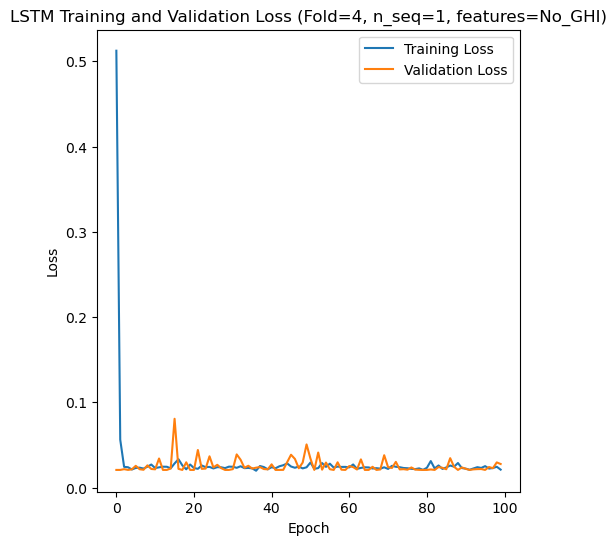

[[0.3359933960190127], [0.6017741117905498], [0.5893141326282043], [0.7420113436964055], [0.5074656965689998]]
[[array(0.3359934)], [array(0.60177411)], [array(0.58931413)], [array(0.74201134)], [array(0.5074657)]]
[[0.2984318976104256], [0.5167776807871733], [0.49925624706528393], [0.6171754647384992], [0.4032952430031516]]
[[0.06452406749940841], [0.1295548301703016], [0.12532918326265563], [0.15962429211891374], [0.09829351380893447]]
[[0.9486400045180086], [0.8810256757543], [0.8433243425088428], [0.19040495458568163], [0.8661629893819571]]
[[array(0.06452407)], [array(0.12955483)], [array(0.12532918)], [array(0.15962429)], [array(0.09829351)]]
[[array(0.97809323)], [array(0.95605519)], [array(0.98335797)], [array(0.81785213)], [array(0.95232505)]]
[3.9  5.74 8.41 5.55 7.36 4.02 6.35 4.55 4.32 4.11 3.76 2.59 6.45 5.07
 5.43 6.41 7.16 2.41 4.68 4.48 3.26 1.64 4.83 4.92 2.95 7.7  3.82 7.31
 6.   4.9  2.74 4.92 5.07 3.58 5.02 4.17 5.29 3.79 3.62 4.35 2.5  3.4
 4.84 3.02 3.96 3.75 7.83

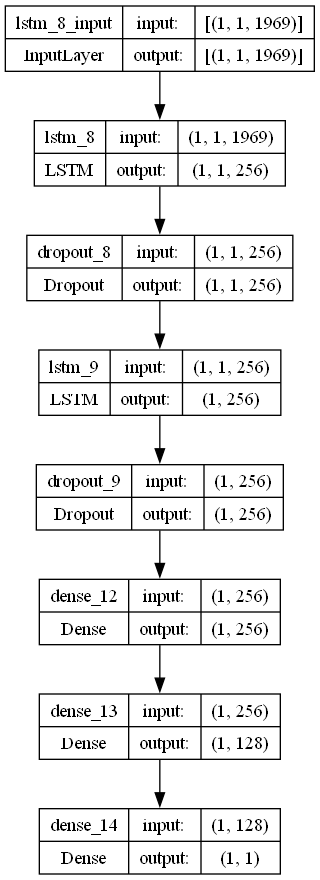

In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def kmape (y_true, y_pred):
    return K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def kpearson (y_true, y_pred):
    mean_true = K.mean(y_true)
    mean_pred = K.mean(y_pred)
    return (K.square(K.mean((y_true - mean_true)*(y_pred - mean_pred))))/(K.mean(K.square(y_true - mean_true))*K.mean(K.square(y_pred - mean_pred)))

# fit the best LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from the best model
    lr = 0.022669202089606346
    optimizer = Adam(learning_rate = lr)
    activation_function = 'relu'
    lstm_units = 256
    dropout_rate = 0.39629399439624596

    # design network
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# Make one forecast with a LSTM
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_lstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# Evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_lstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# Invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # Invert the first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Propagate the difference forecast using the inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# Inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create an array from the forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# Evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(actual, forecasts, n_lag, n_seq):

    t = np.array(actual).transpose()
    f = np.array(forecasts).transpose()

    print("f, t:")
    print(t)
    print(f)
    rmse_list = []
    mae_list = []
    skmape_list = []
    mape_list = []
    r2_list = []
    pearson_list = []
    actual_list = []

    for i in range(n_seq):
        act = [row for row in t[i]]
        predicted = [forecast for forecast in f[i]]
        rmse1 = sqrt(mean_squared_error(act, predicted))
        rmse2 = np.array(rmse(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        mae = mean_absolute_error(act, predicted)
        mse = mean_squared_error(act, predicted)
        skmape = mean_absolute_percentage_error(act, predicted)
        kmape1 = np.array(kmape(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        kpearson1 = np.array(kpearson(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        r2 = r2_score(act, predicted) 
        avg_actual = np.mean(act)
        print("Year at t+"+str(i+1)+":")
        print('t+%d SKRMSE: %f' % ((i+1), rmse1))
        print('t+%d KRMSE: %f' % ((i+1), rmse2))        
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d SKMAPE: %f' % ((i+1), skmape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))
        print('t+%d KMAPE: %f' % ((i+1), kmape1))
        print('t+%d PEARSON: %f' % ((i+1), kpearson1))
        print('t+%d AVERAGE ACTUAL: %f' % ((i+1), avg_actual))

    y_true = tf.convert_to_tensor(np.array(actual).flatten())
    y_pred = tf.convert_to_tensor(np.array(forecasts).flatten())

    rmse1 = sqrt(mean_squared_error(np.array(y_true), np.array(y_pred)))
    rmse2 = np.array(rmse(y_true, y_pred))
    mae = mean_absolute_error(np.array(y_true), np.array(y_pred))
    mse = mean_squared_error(np.array(y_true), np.array(y_pred))
    skmape = mean_absolute_percentage_error(np.array(y_true), np.array(y_pred))
    kmape1 = np.array(kmape(y_true, y_pred))
    kpearson1 = np.array(kpearson(y_true, y_pred))
    r2 = r2_score(np.array(y_true), np.array(y_pred)) 
    avg_actual = np.mean(np.array(y_true))
    rmse1_list.append(rmse1)
    rmse2_list.append(rmse2)
    mae_list.append(mae)
    skmape_list.append(skmape)
    pearson_list.append(kpearson1)
    mape_list.append(kmape1)
    r2_list.append(r2)
    actual_list.append(avg_actual)
    print("Metrics for this Fold:")
    print('SKRMSE: %f' % (rmse1))
    print('KRMSE: %f' % (rmse2))        
    print('MAE: %f' % (mae))
    print('SKMAPE: %f' % (skmape))
    print('R2_SCORE: %f' % (r2))
    print('KMAPE: %f' % (kmape1))
    print('PEARSON: %f' % (kpearson1))
    print('AVERAGE ACTUAL: %f' % (avg_actual))

    return rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list, actual_list
     
# plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, actual, n_test, n_seq, n_lag):
    # plot the entire dataset in blue
    plt.plot(series[:n_lag+2+len(forecasts)].values)
    # plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    print(xaxis)
    print(yaxis)
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Month")
    plt.ylabel("Specific Humidity")
    # show the plot
    plt.show()

n_batch = 1
n_test = 11
nb_epoch = 100
    
rmse1_avg_list = []
rmse2_avg_list = []
mae_avg_list = []
skmape_avg_list = []
r2_score_avg_list = []
mape_avg_list = []
pearson_avg_list = []
actual_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]
    
    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:10, :]
    dataset = dataset_df.values

    print(dataset)

    series = pd.Series(dataset[:, 0]) # Using first column (specific_humidity)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))
    
    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test, n_seq)

    # Print out plots of actual and predicted values for weather stations
    ws = df.index[1:12]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    print(results_df)
    
    print("Actual and Forecasts:")
    print(actual)
    print(forecasts)
    
    for j in range(11):
        print("Weather Station "+str(j+1)+":")
        print("Actual S.H.\tPredicted S.H.\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")
    
        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:11, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (temperatures)
        forecasts_ws = forecasts[j]
        actual_ws = actual[j]
        
        plot_forecasts(series_ws, forecasts_ws, actual_ws, n_test, n_seq, n_lag)

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(11):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)

        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='LSTM Model Comparison Specific Humidity Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_GHI)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Specific Humidity')
        plt.legend()
        plt.show()

    rmse1_list = [] # list stores sklearn's root mean squared errors for each future time prediction
    rmse2_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores mean absolute errors for each future time prediction
    skmape_list = [] # list stores sklearn's mean squared percentage errors for each future time prediction
    r2_list = [] # list stores sklearn's r2 pearson values for each future time prediction
    mape_list = [] # list stores mean squared percentage errors for each future time prediction
    pearson_list = [] # list stores r2 pearson values for each future time prediction
    actual_list = [] # list stores average actual values for each future time prediction

    # evaluate forecasts
    rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list, actual_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse1_avg_list.append(rmse1_list)
    rmse2_avg_list.append(rmse2_list)
    mae_avg_list.append(mae_list)
    skmape_avg_list.append(skmape_list)
    r2_score_avg_list.append(r2_list)
    mape_avg_list.append(mape_list)
    pearson_avg_list.append(pearson_list)
    actual_avg_list.append(actual_list)
    forecast_results.append(forecasts)
    actual_results.append(actual)
            
    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_GHI)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse1_avg_list)
print(rmse2_avg_list)
print(mae_avg_list)
print(skmape_avg_list)
print(r2_score_avg_list)
print(mape_avg_list)
print(pearson_avg_list)
print(np.array(actual_results).flatten())
print(np.array(forecast_results).flatten())
a2 = np.array(actual_results).flatten()
f2 = np.array(forecast_results).flatten()
p1 = np.array(pearson(tf.convert_to_tensor(a2), tf.convert_to_tensor(f2)))
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse1_avg_list)
print("Average SKRMSE:"+str(np.mean(rmse1_avg_list)))
print("Average KRMSE:"+str(np.mean(rmse2_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average SKMAPE:"+str(np.mean(skmape_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average PEARSON:"+str(p1))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))
print("")
print("Average Specific Humidity:"+str(np.mean(actual_avg_list)))
print("RMSE % of Specific Humidity:"+str(np.mean(rmse2_avg_list)/np.mean(actual_avg_list)))

# Plot model architecture
filename = "lstm_model_optimized_SH_S1_No_GHI.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)